# IWSSS Paper Analysis

**Author:** Christian Decker (http://cdeck3r.com)

**Synopsis**

The International Workshop on Smart Sensing Systems (IWSSS) 2019 is the fourth in the series since 2016. In takes place in conjunction with the 15th International Conference on Intelligent Environments (IE'19) in Rabat, Morocco. 

This R notebook analyzes a data set containing title and abstract of the IWSSS publications from 2016 until 2019. 

**Motivation**

Smart sensing system is an active research field involving expertise from many different areas ranging from sensor processing at one end to applications on the other end. 

> The Workshop is a forum for exchange of experience among researchers from industry and academia actively involved in research, development and evaluation of new concepts, theoretical methods and experimental characterization and for debating different innovative solutions. It aims to bring together topics from several layers of data processing; from devices to services to enable novel ideas and collaboration combining the information from multiple sources.

_Source: https://iwsss19.github.io/_

By this motivation, IWSSS undergoes a permanent change of topics discussed throughout the last years. The group of authors changes as well as IWSSS may be the entry door for young researchers to enter the field and to get involved with the scientific community investigating smart sensing systems.

The author of this notebook believes, it is valueable to review the presented developments of the last years.

**Objective**

Make the evolution of the field and topics within the IWSSS format  visible. 

**Research Questions**

* How to explore the papers' context to achieve a general understanding?
* What are strong relations connecting all documents with each other?
* What are relevant papers to read?
* What are topics and how do papers correspond to these topics?
* Topic evolution: How much are past topics still present in  IWSSS?

**Method**

We utilize qualitative and quantitative methods from NLP applied to titles and paper abstracts in order to provide answers to these questions. A paper abstract or title refers to a document in NLP. The pile of papers form a document corpus, or simply corpus.

Note, this is not an automated literature analysis. Nevertheless, some of the techiques may be utilized for it.


**Technical notes**

**Input:** `iwsss_paper_dataset.xlsx`

**Acknowledments**

The analysis follows the case study *Case study: mining NASA metadata* from https://www.tidytextmining.com/nasa.html


In [1]:
# define vars
paper_dir <- '../data'
xlsx_file <- file.path(paper_dir, 'iwsss_paper_dataset.xlsx')

In [2]:
# define plot sizes
options(repr.plot.width=7, repr.plot.height=7, repr.plot.res=300)

**Load required libs**

In [3]:
# load necessary libs
library(tidyr)
library(tidytext)
library(dplyr)
library(stringr)
library(purrr)
library(readxl)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Data Loading and Wrangling

In [4]:
dataset <- read_excel(path=xlsx_file, sheet="PaperData")
dataset <- dataset %>% filter(complete == TRUE)
cat("Number of data rows: ", nrow(dataset))

Number of data rows:  31

In [5]:
# some data wrangling
dataset_title <- dataset %>% 
    unnest_tokens(word, MET_TITLE) %>%
    anti_join(stop_words, by="word") %>%
    select(year, filename, word)

dataset_abstract <- dataset %>% 
    unnest_tokens(word, MET_ABSTRACT) %>%
    anti_join(stop_words, by= "word") %>%
    select(year, filename, word)

Filenames from the dataset are required to be unique. Check this constraint.

In [6]:
# unique filenames

## IWSSS Papers

We provide a brief overview on the number of papers per year. Please note that the publication format and conjunct conference has changed since the initial start in 2016. As a consequence, it is not valid to conclude on the attraction or quality of IWSS throughout the years.

Additionally, we plot the average title and abstract length for papers in each year. Stopwords are removed.

In [7]:
papers_per_year <- dataset %>% 
    group_by(year) %>%
    summarise(paper_count = n())

avg_title_length_per_year <- dataset_title %>%
    select(year, word) %>%
    count(year, word, sort = TRUE) %>%
    group_by(year) %>%
    summarise(title_word_count = sum(n)) %>%
    inner_join(papers_per_year, by=c("year")) %>%
    mutate(avg_title_word_count = title_word_count/paper_count)

avg_abstract_length_per_year <- dataset_abstract %>%
    select(year, word) %>%
    count(year, word, sort = TRUE) %>%
    group_by(year) %>%
    summarise(abstract_word_count = sum(n)) %>%
    inner_join(papers_per_year, by=c("year")) %>%
    mutate(avg_abstract_word_count = abstract_word_count/paper_count)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




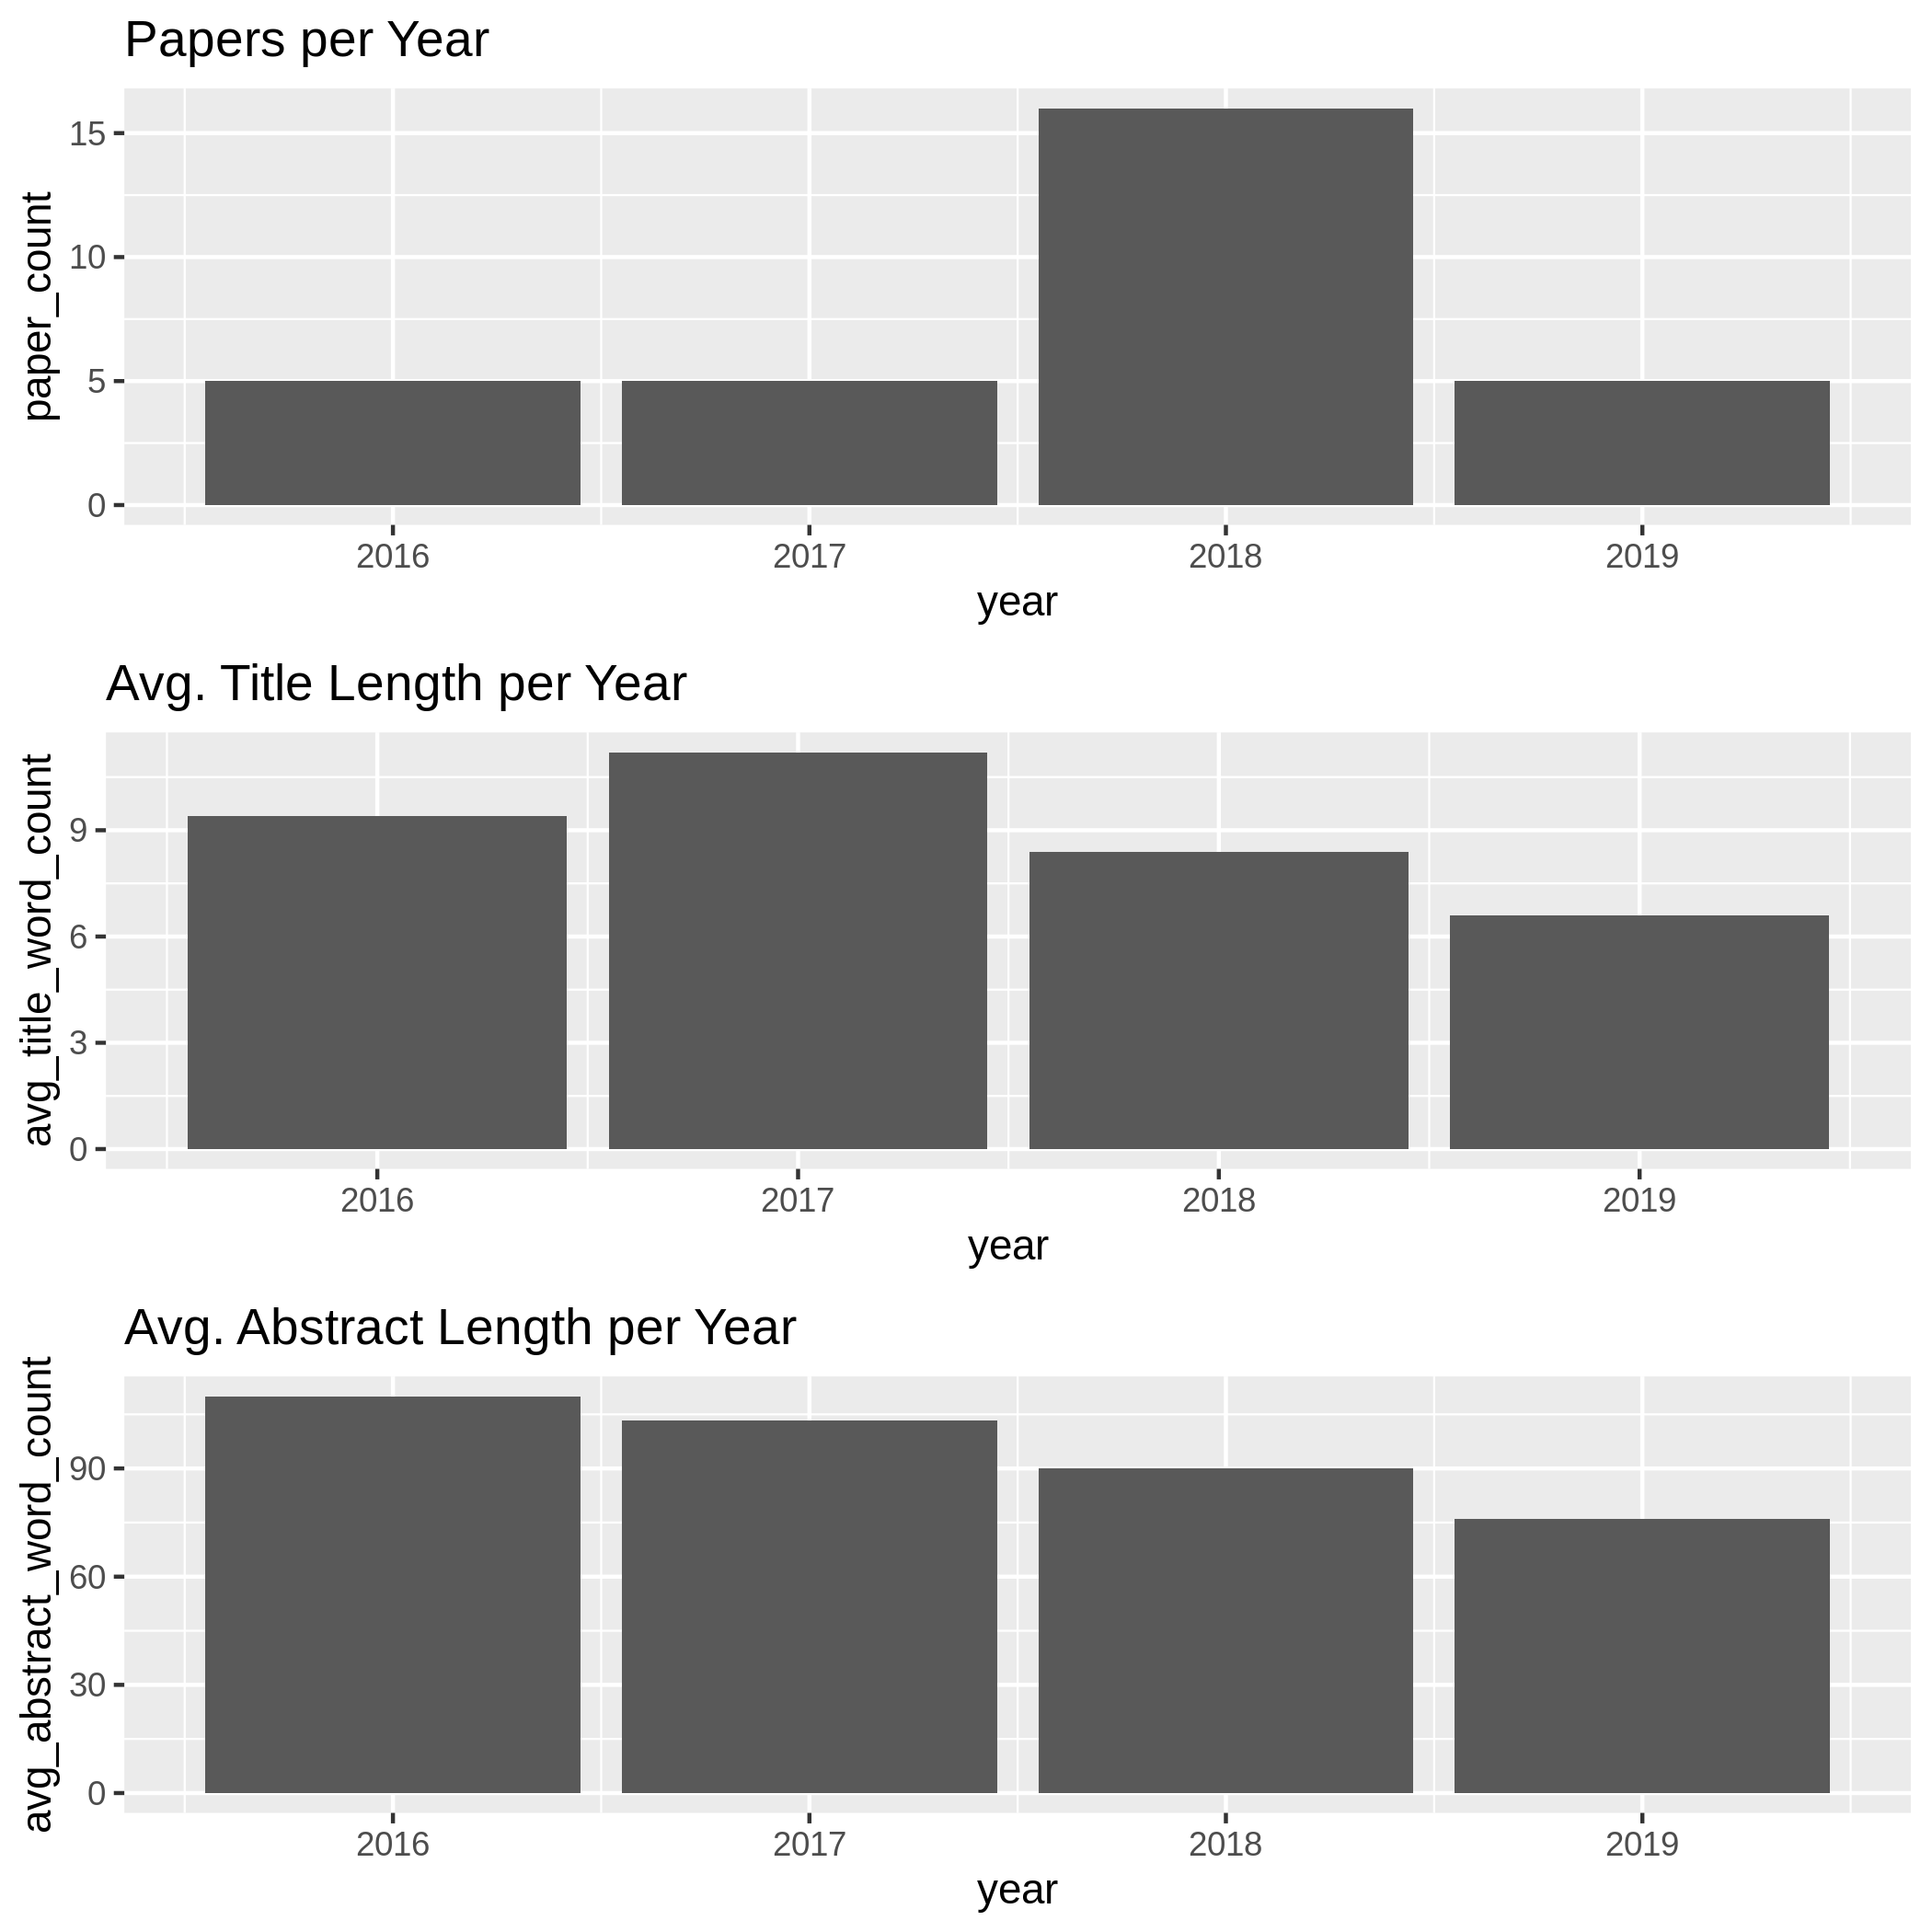

In [8]:
library(ggplot2)
library(gridExtra)

plot.papers_per_year <- ggplot(data=papers_per_year, 
                               aes(x=year, 
                                   y=paper_count)) +
    geom_bar(stat="identity") + 
    ggtitle("Papers per Year")
plot.title_length_per_year <- ggplot(data=avg_title_length_per_year, 
                                     aes(x=year, 
                                         y=avg_title_word_count)) +
    geom_bar(stat="identity") +
    ggtitle("Avg. Title Length per Year")
plot.abstract_length_per_year <- ggplot(data=avg_abstract_length_per_year, 
                                     aes(x=year, 
                                         y=avg_abstract_word_count)) +
    geom_bar(stat="identity") +
    ggtitle("Avg. Abstract Length per Year")

grid.arrange(plot.papers_per_year,
             plot.title_length_per_year, 
             plot.abstract_length_per_year,
             nrow=3)

## Exploration

We qualitatively and qualitatively review the titles and paper abstracts of the entire IWSSS series. Quantitative exploration utilizes 

* wordclouds visualizations 

Quantitative exploration starts by using word counts and will derive and apply additional data wrangling measures, e.g. additional stop words. Afterwards, we explore various word correspondences on

* bi- and trigrams
* word pairs
* word correlations


### Wordcloud

A wordcloud provides a qualitative visualization of text.

Code is taken from: http://www.sthda.com/english/wiki/text-mining-and-word-cloud-fundamentals-in-r-5-simple-steps-you-should-know


In [9]:
library(tm)
library(wordcloud)

Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:ggplot2’:

    annotate


Loading required package: RColorBrewer



The wordcloud of titles.

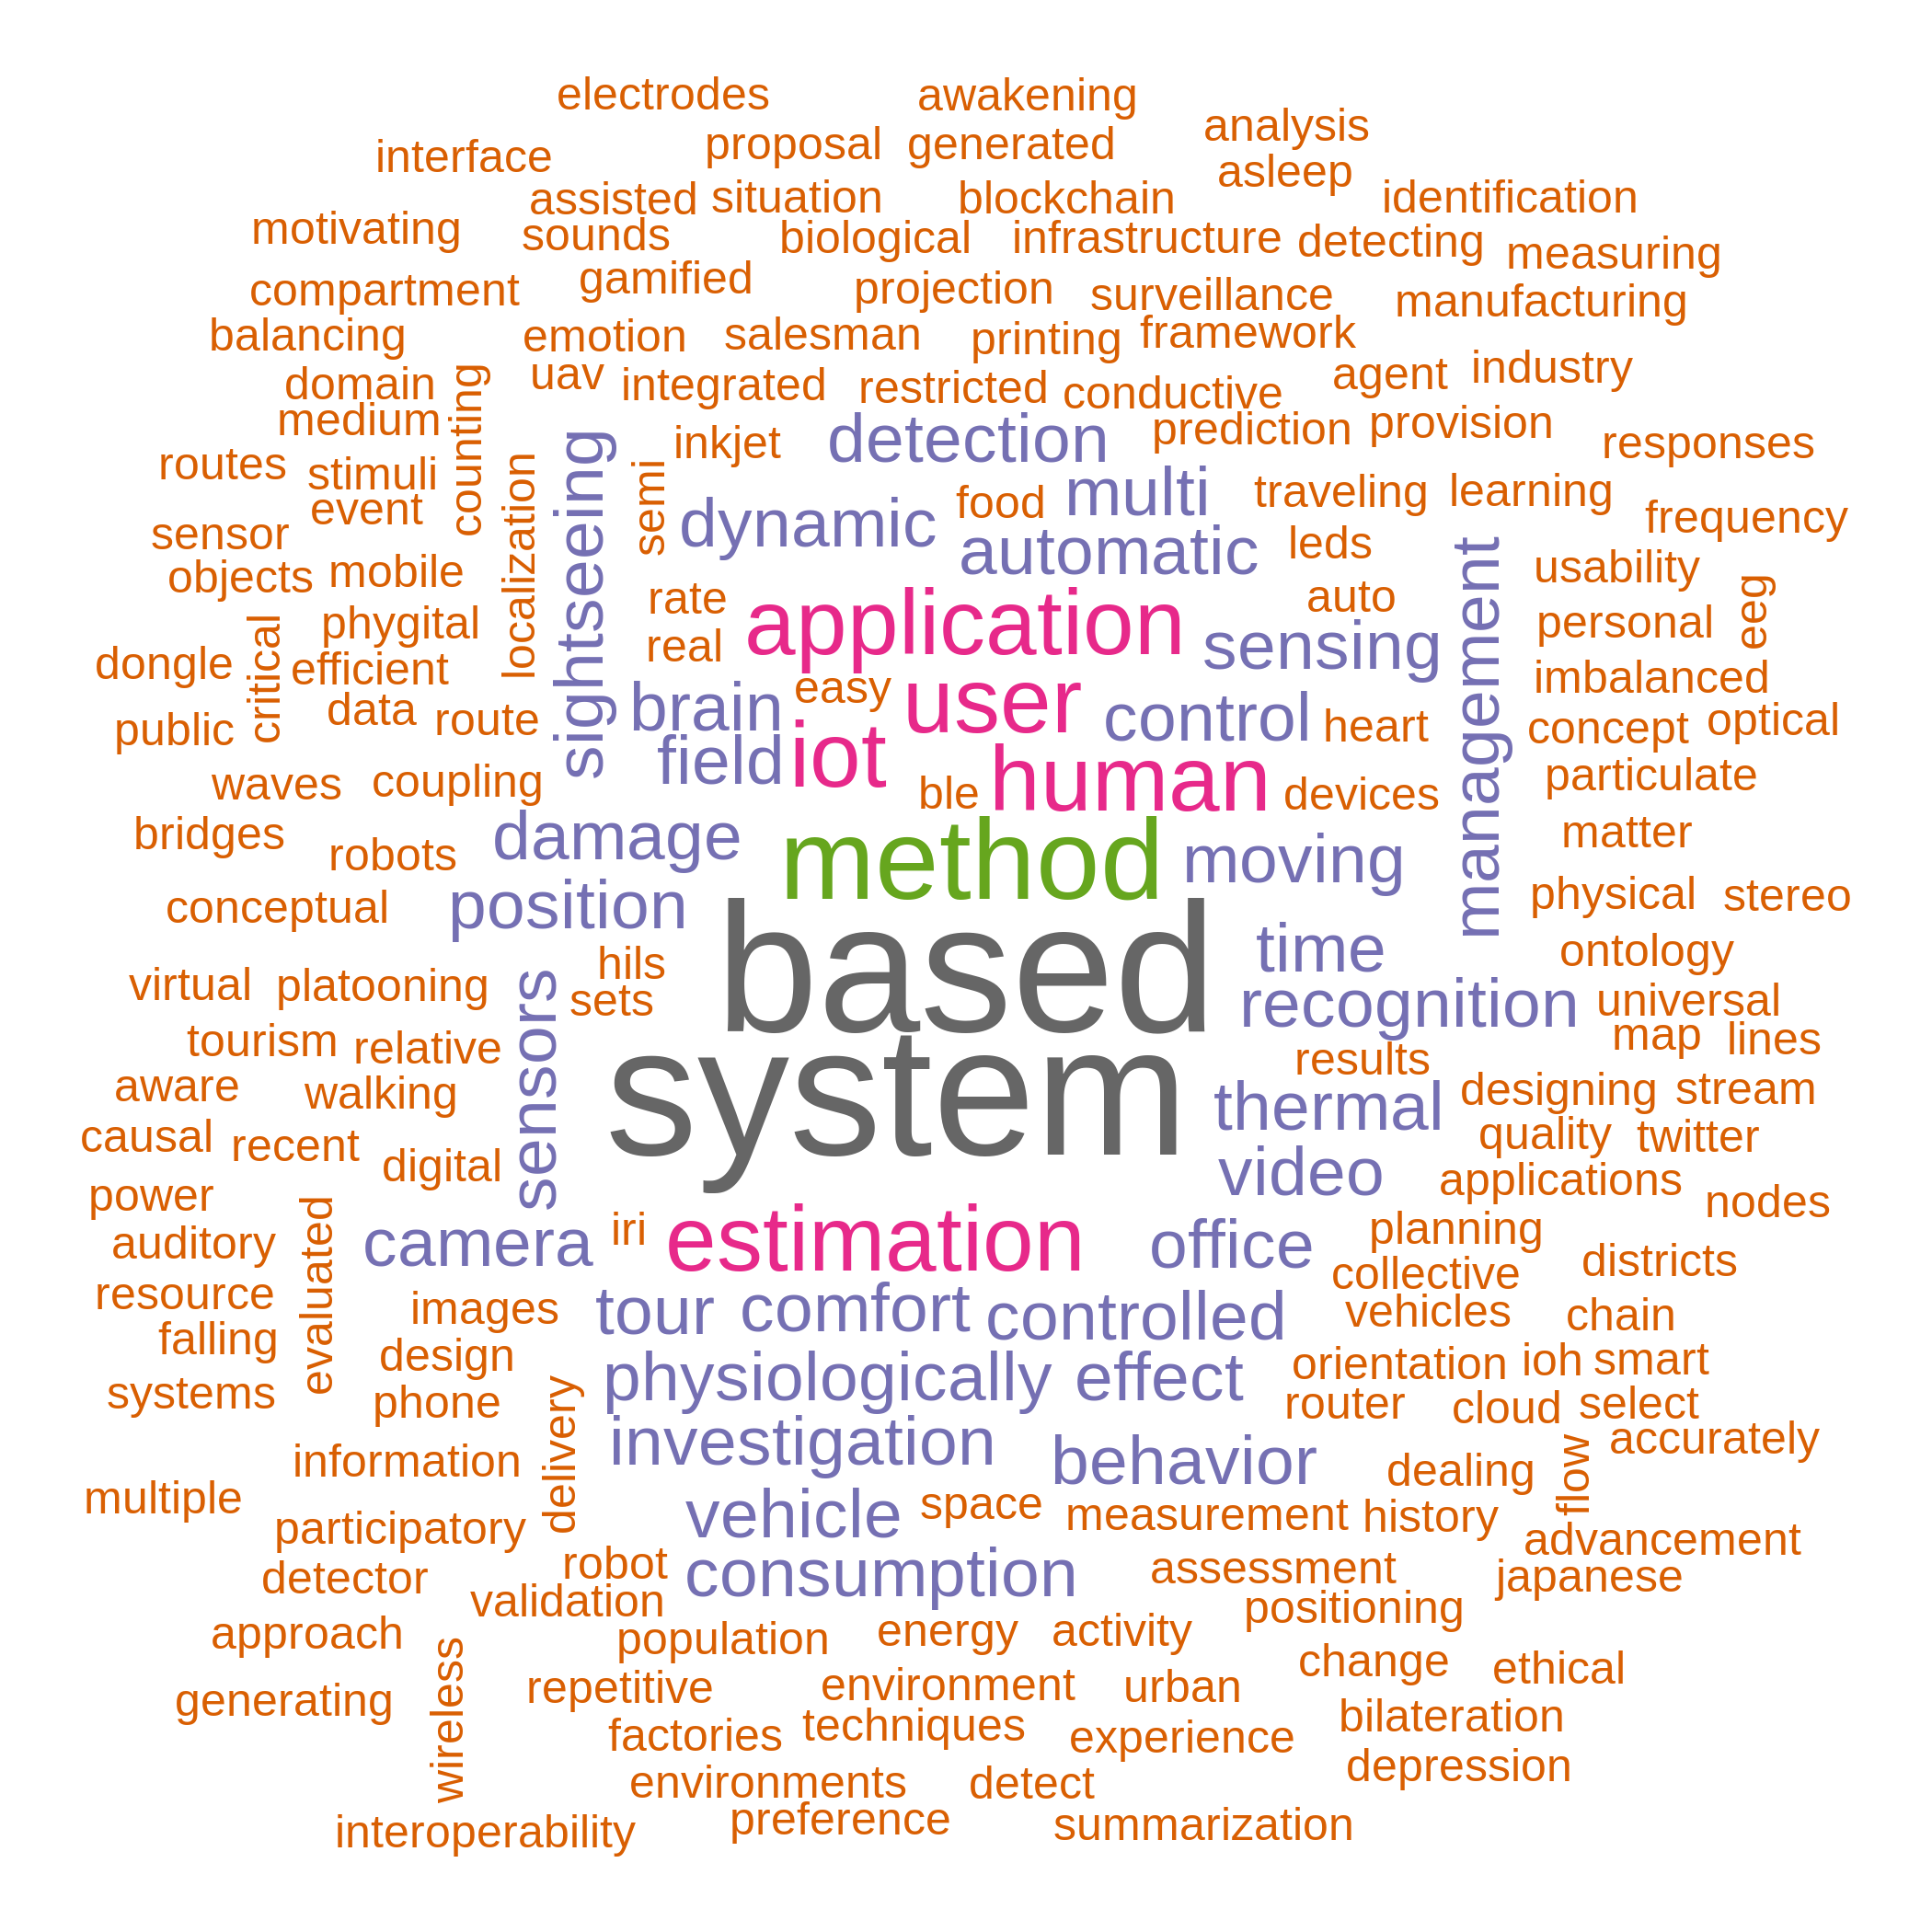

In [10]:
title_dtm <- dataset_title %>%
  count(filename, word, sort = TRUE) %>%
  ungroup() %>%
  cast_dtm(filename, word, n)

m <- as.matrix(title_dtm)
v <- sort(colSums(m),decreasing=TRUE)
d <- data.frame(word = names(v),freq=v)

set.seed(1234)
wordcloud(words = d$word, freq = d$freq, min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.1, 
          colors=brewer.pal(8, "Dark2"))


The wordcloud of abstracts.

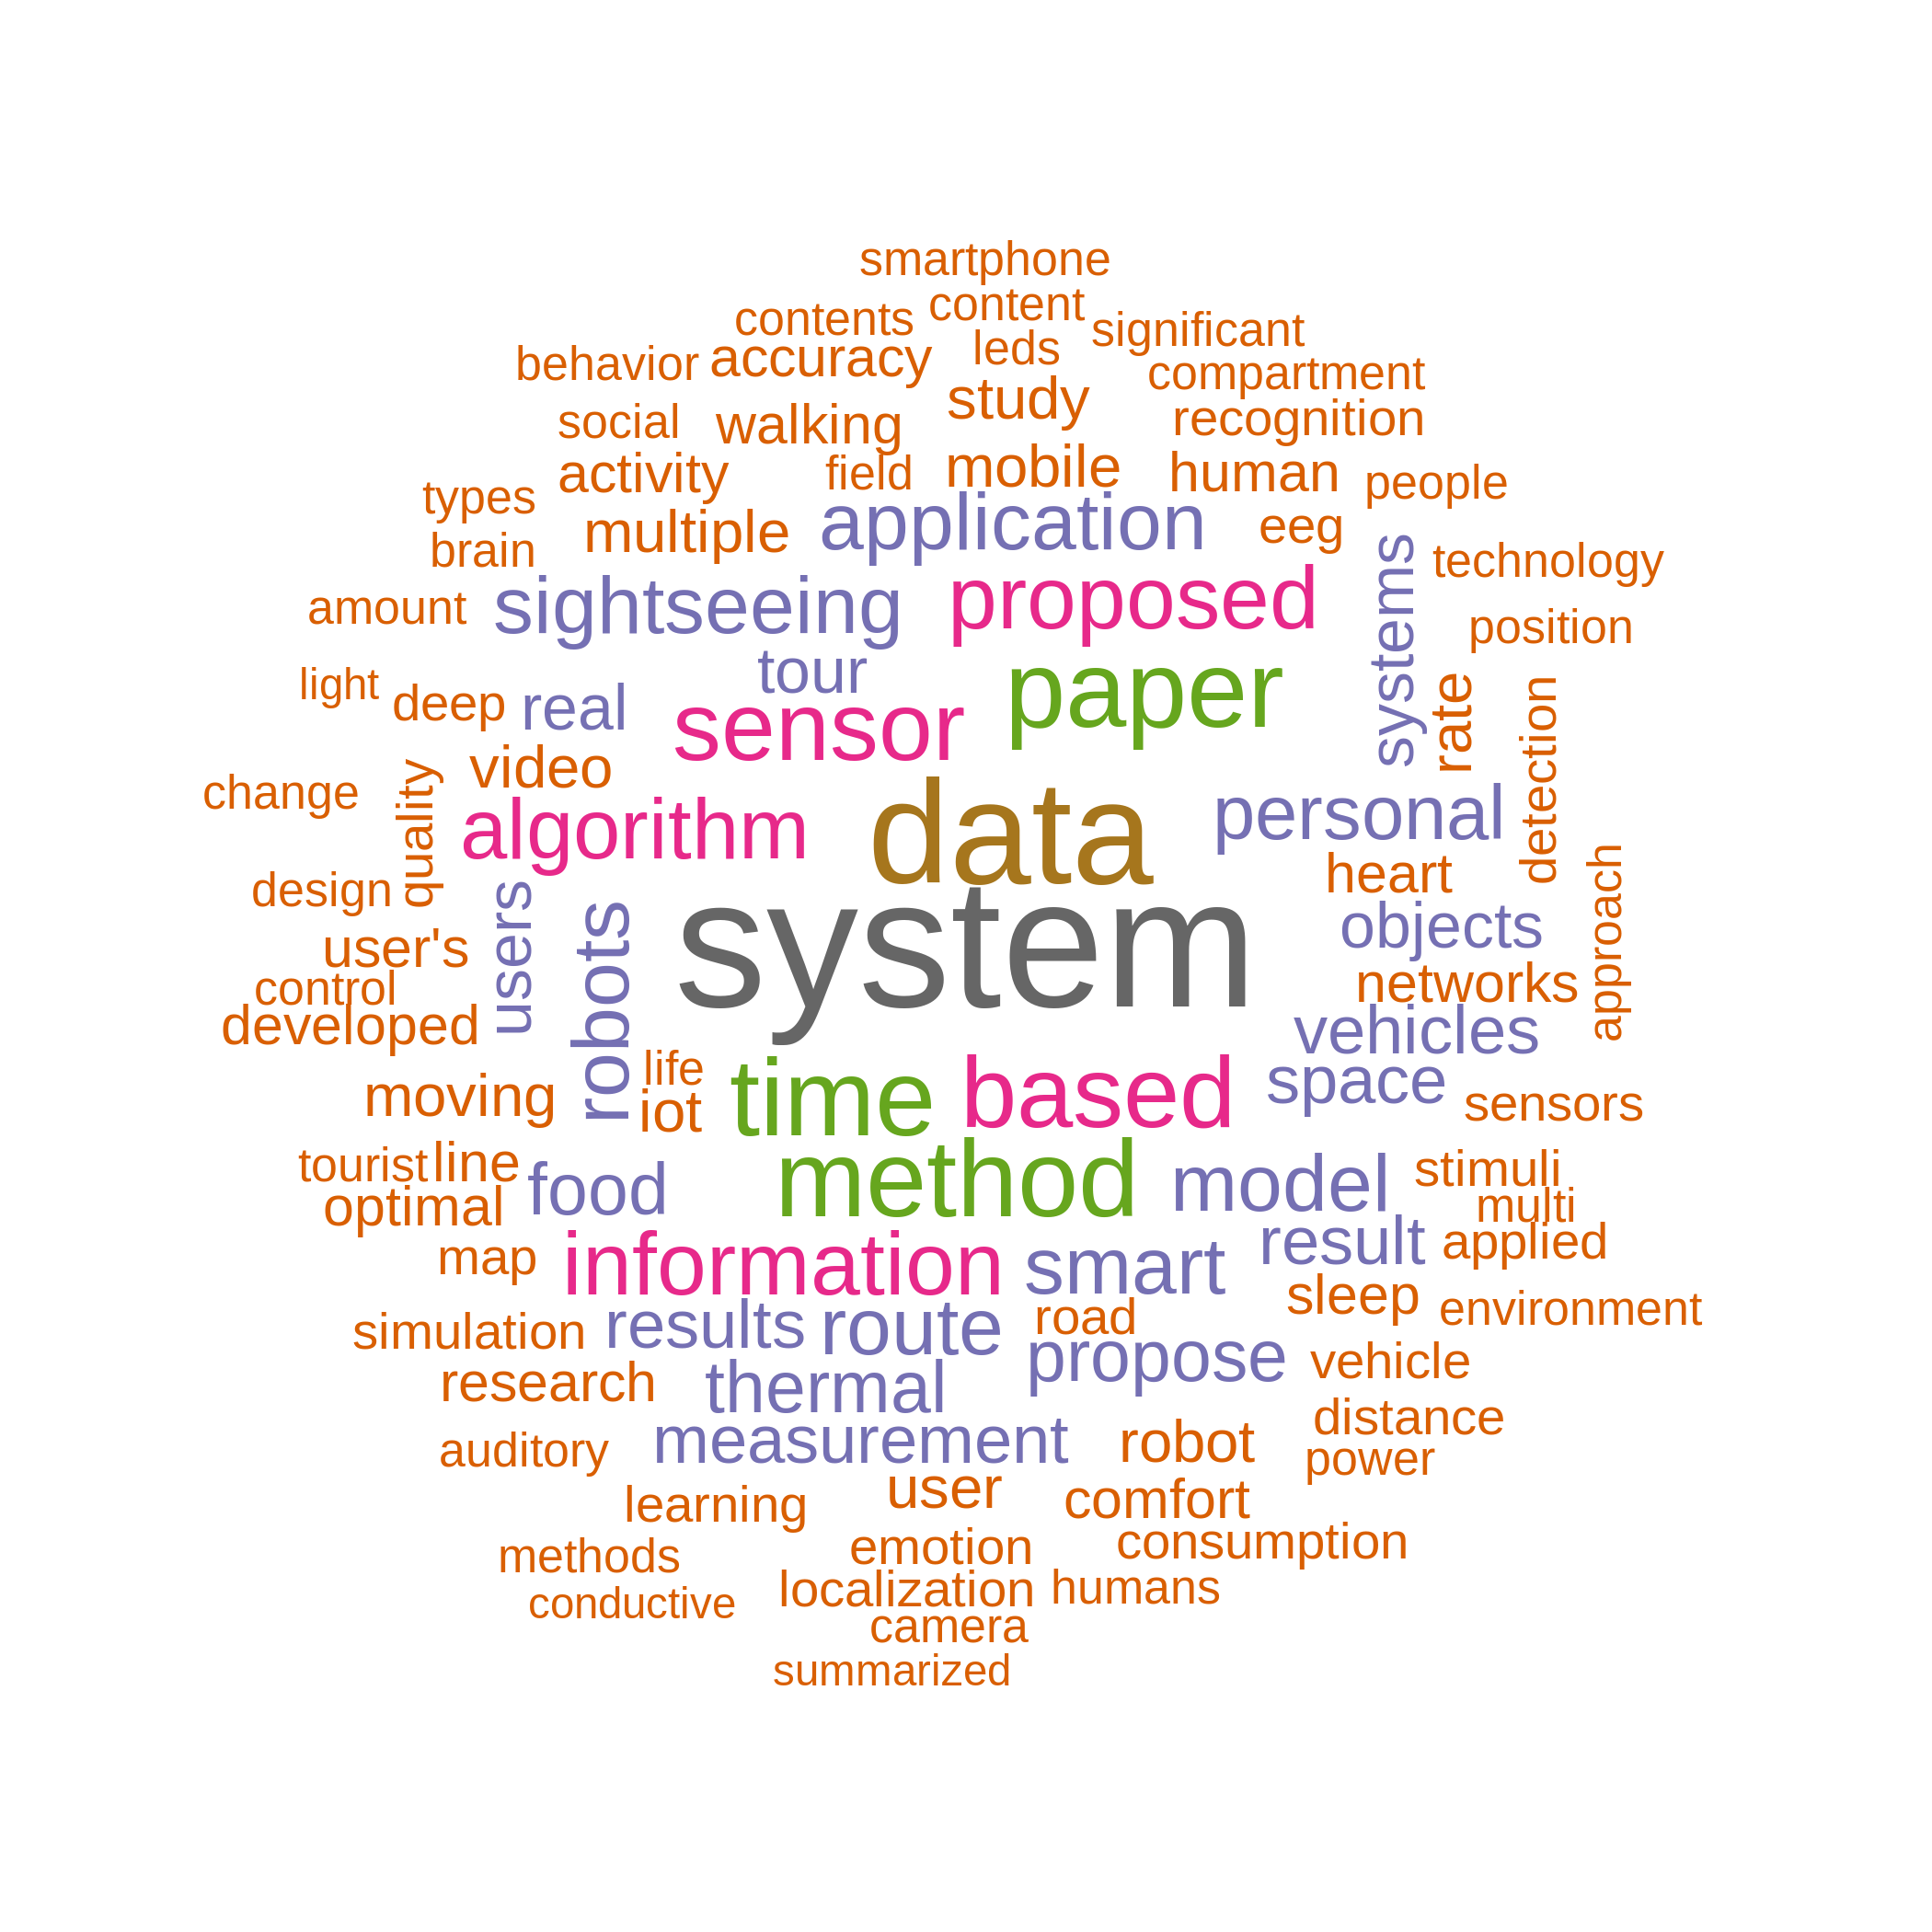

In [11]:
abstract_dtm <- dataset_abstract %>%
  count(filename, word, sort = TRUE) %>%
  ungroup() %>%
  cast_dtm(filename, word, n)

m <- as.matrix(abstract_dtm)
v <- sort(colSums(m),decreasing=TRUE)
d <- data.frame(word = names(v),freq=v)

set.seed(1234)
wordcloud(words = d$word, freq = d$freq, min.freq = 1,
          max.words=100, random.order=FALSE, rot.per=0.1, 
          colors=brewer.pal(8, "Dark2"))

### Word Counts

We list the topN words from titles and abstract.

In [12]:
dataset_title %>% count(word, sort = TRUE)  %>% top_n(4, n)

word,n
<chr>,<int>
based,7
system,7
method,4
application,3
estimation,3
human,3
iot,3
user,3


In [13]:
dataset_abstract %>% count(word, sort = TRUE)  %>% top_n(10, n)

word,n
<chr>,<int>
system,39
data,30
method,21
paper,21
time,21
based,19
sensor,18
information,16
proposed,16


We find the words $\{$ `paper`, `data` , `based`, `proposed`, `propose` $\}$ among the top10 words of the abstracts. These are very generic. As a consequence, we  add them to the stopwords. Additionally, we stem the words from abstracts.

In [14]:
# add new stop words
new_stopwords = c("paper", "data", "based", "proposed", "propose")
stopwords <- data_frame(word = new_stopwords, stringsAsFactors = FALSE)
dataset_abstract <- dataset_abstract %>% 
    anti_join(stopwords, by="word")

# stemming 
library(SnowballC)

dataset_abstract <- dataset_abstract %>%
    mutate(word = wordStem(word))

dataset_abstract %>% count(word, sort = TRUE)  %>% top_n(10, n)

Warning message:
“`data_frame()` is deprecated as of tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


word,n
<chr>,<int>
system,49
method,27
sensor,25
time,24
measur,23
result,23
robot,23
applic,19
model,19


### Bigrams and Trigrams

n-grams denote a sequence of n consecutive words. A bigram consists of a sequence of two words; a trigram of three words. The n-gram analysis identifies frequent word sequences throughout all paper abstracts.

In [15]:
library(dplyr)
library(purrr)

c(2,3) %>% map_df( function(ng) {
    dataset %>% 
    unnest_tokens(ngram, MET_ABSTRACT, token = "ngrams", n = ng) %>%
    select(filename, ngram) %>%
    separate(ngram, c("word1", "word2", "word3"), sep = " ") %>%
    filter(!word1 %in% stop_words$word) %>%
    filter(!word2 %in% stop_words$word) %>%
    filter(!word3 %in% stop_words$word) %>%
    count(word1, word2, word3, sort=TRUE) %>% replace_na(list(word3="")) %>%
    top_n(5, n) 
    } )

Warning message:
“Expected 3 pieces. Missing pieces filled with `NA` in 5452 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


word1,word2,word3,n
<chr>,<chr>,<chr>,<int>
personal,space,,11
heart,rate,,8
thermal,comfort,,8
proposed,method,,7
auditory,stimuli,,6
compartment,line,,6
real,time,,6
food,supply,chain,4
deep,brain,activities,3


### Network of Word Pairs

Pairs are different from bigrams. A pair is the co-occurence of two words within a document (either a title or an abstract). The pairwise count is the number of the pair's appearences across all documents. A bigram is the co-occurence of two words within a sequence of words.

A pair appeares only once per document. A bigram may be found several times per document.



In [16]:
library(widyr)

# form word pairs for both, title and abstract
title_word_pairs <- dataset_title %>% 
  pairwise_count(word, filename, sort = TRUE, upper = FALSE)

abstract_word_pairs <- dataset_abstract %>% 
  pairwise_count(word, filename, sort = TRUE, upper = FALSE)



Attaching package: ‘igraph’


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




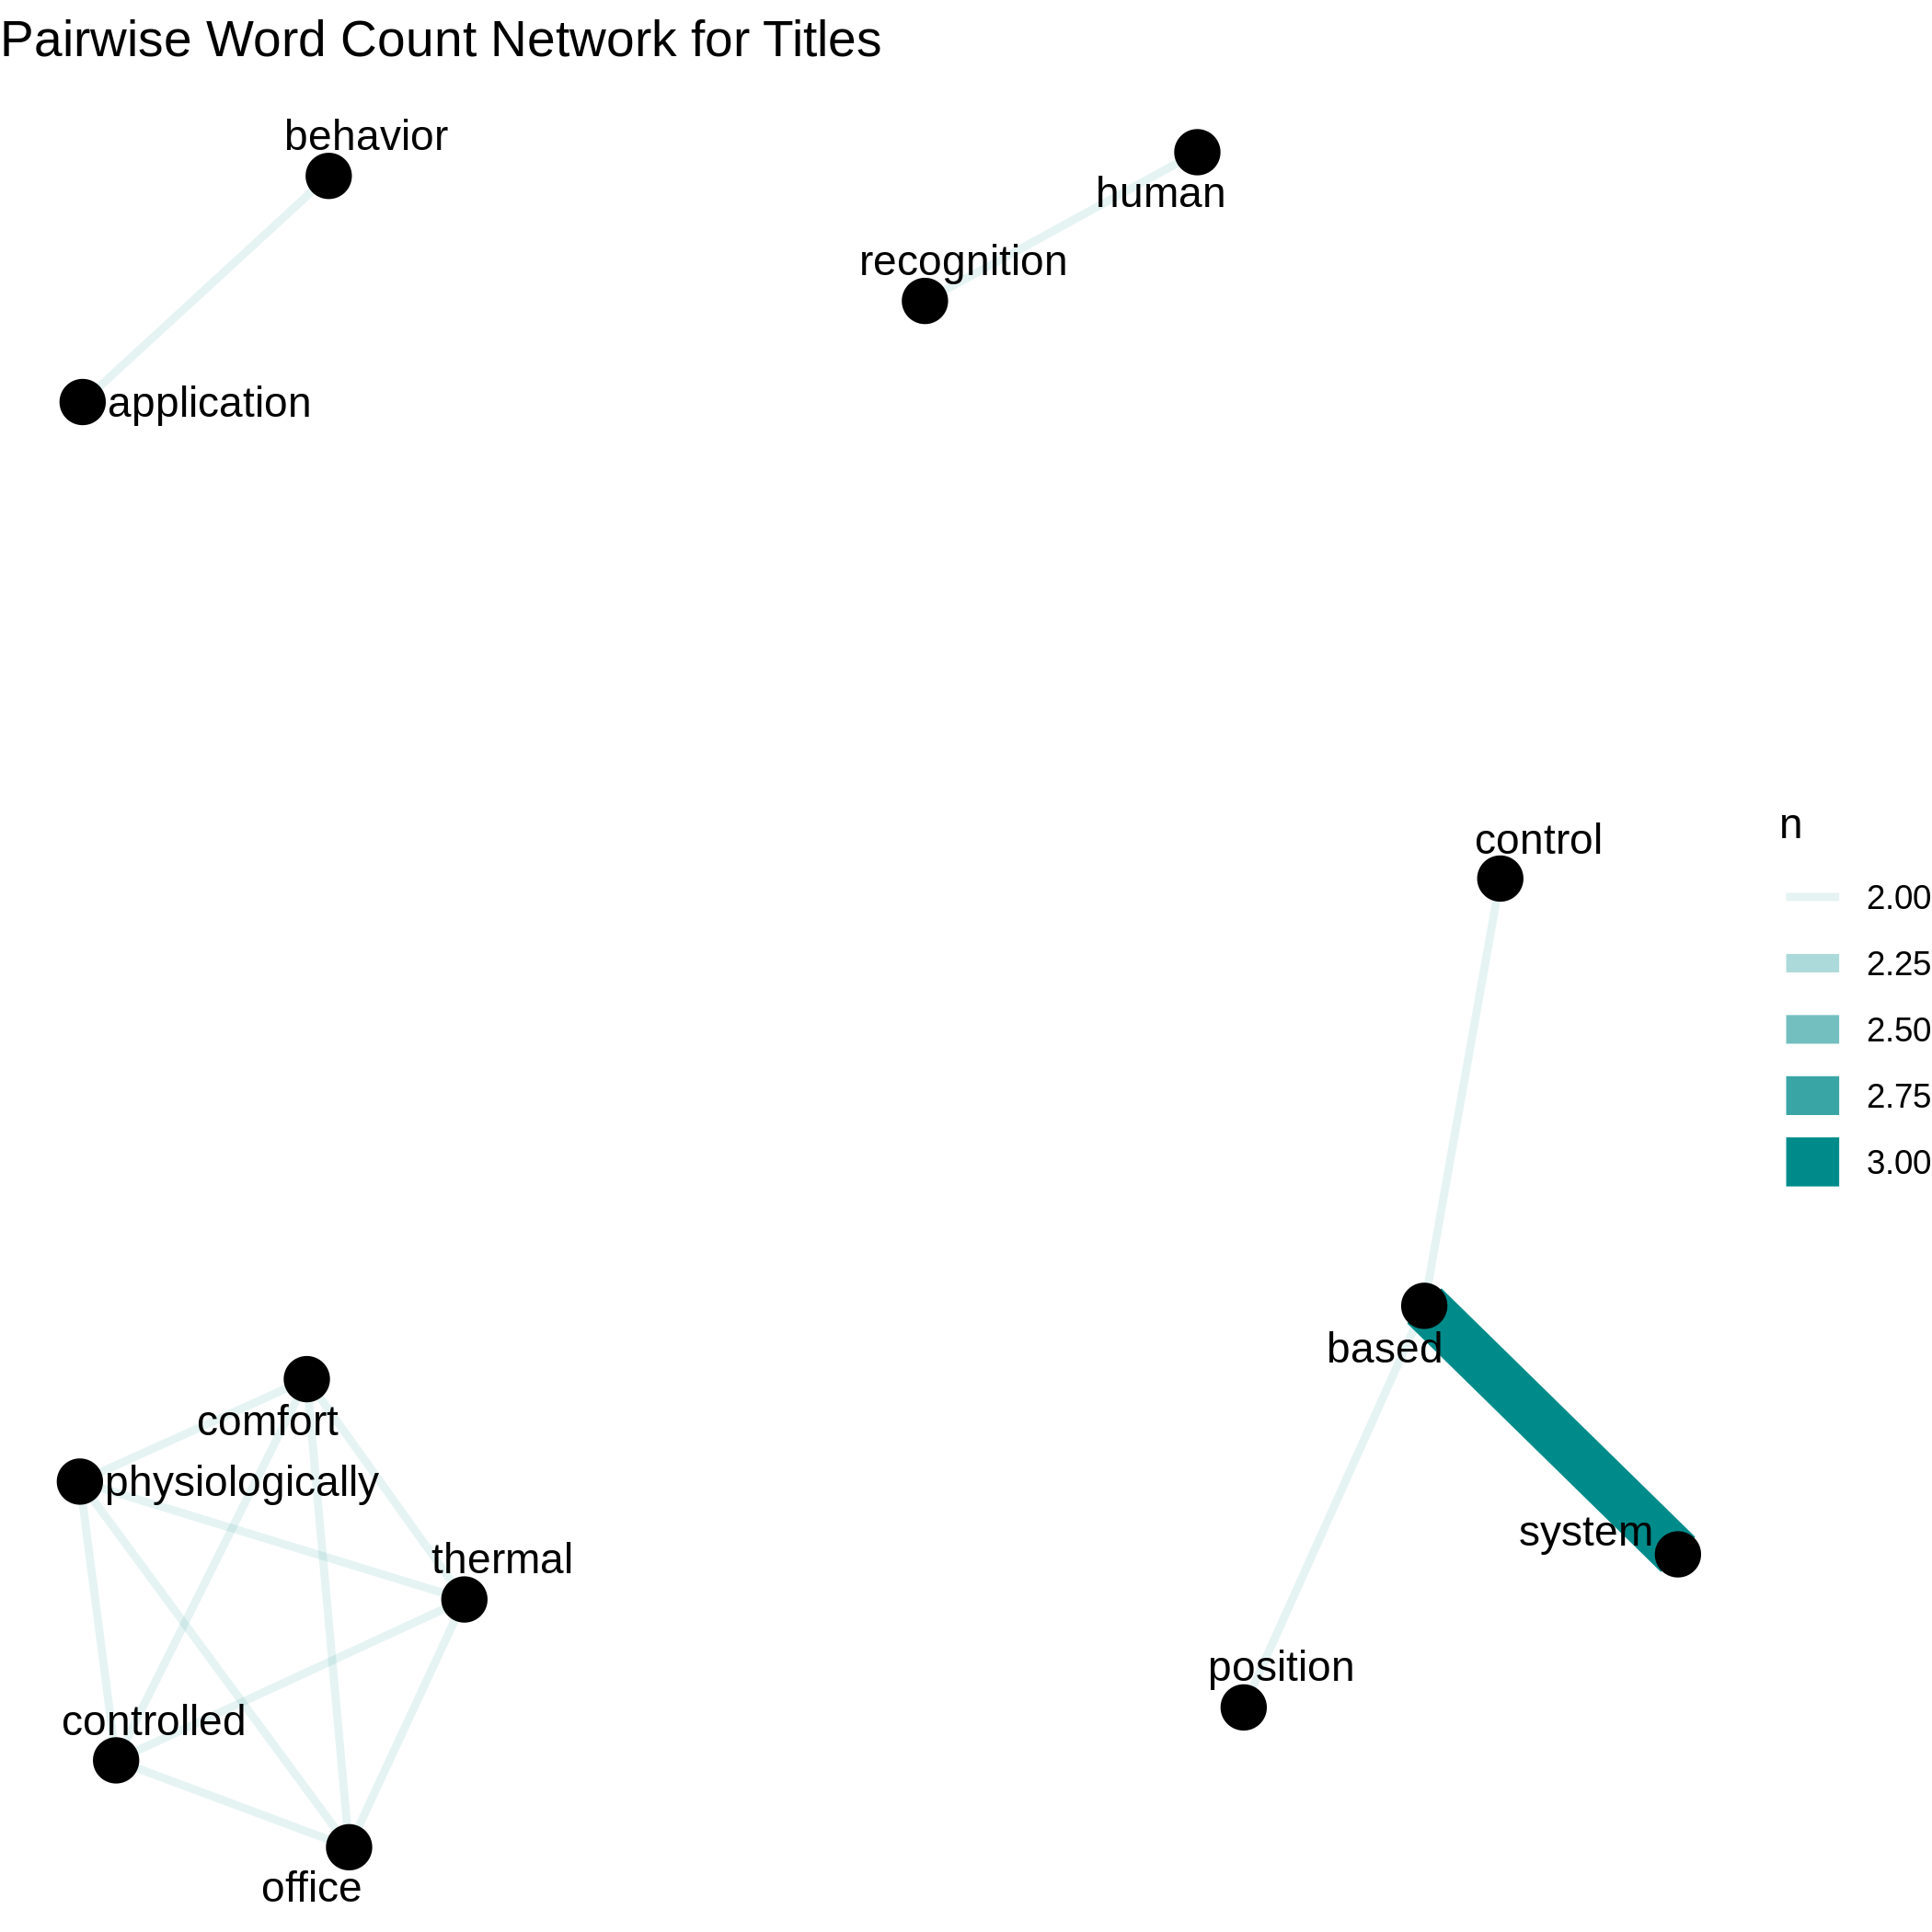

In [17]:
library(ggplot2)
library(igraph)
library(ggraph)

set.seed(1234)
title_word_pairs %>%
  filter(n >= 2) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = n, edge_width = n), edge_colour = "cyan4") +
  geom_node_point(size = 5) +
  geom_node_text(aes(label = name), repel = TRUE, 
                 point.padding = unit(0.2, "lines")) +
  ggtitle("Pairwise Word Count Network for Titles") +
  theme_void()

Word count networks of titles form a few clusters. However, overall the counts are very low since titles resemble very short documents. 

Let's apply word counts to longer texts - the papers' abstracts. Beforehand we perform stemming on abstracts.  

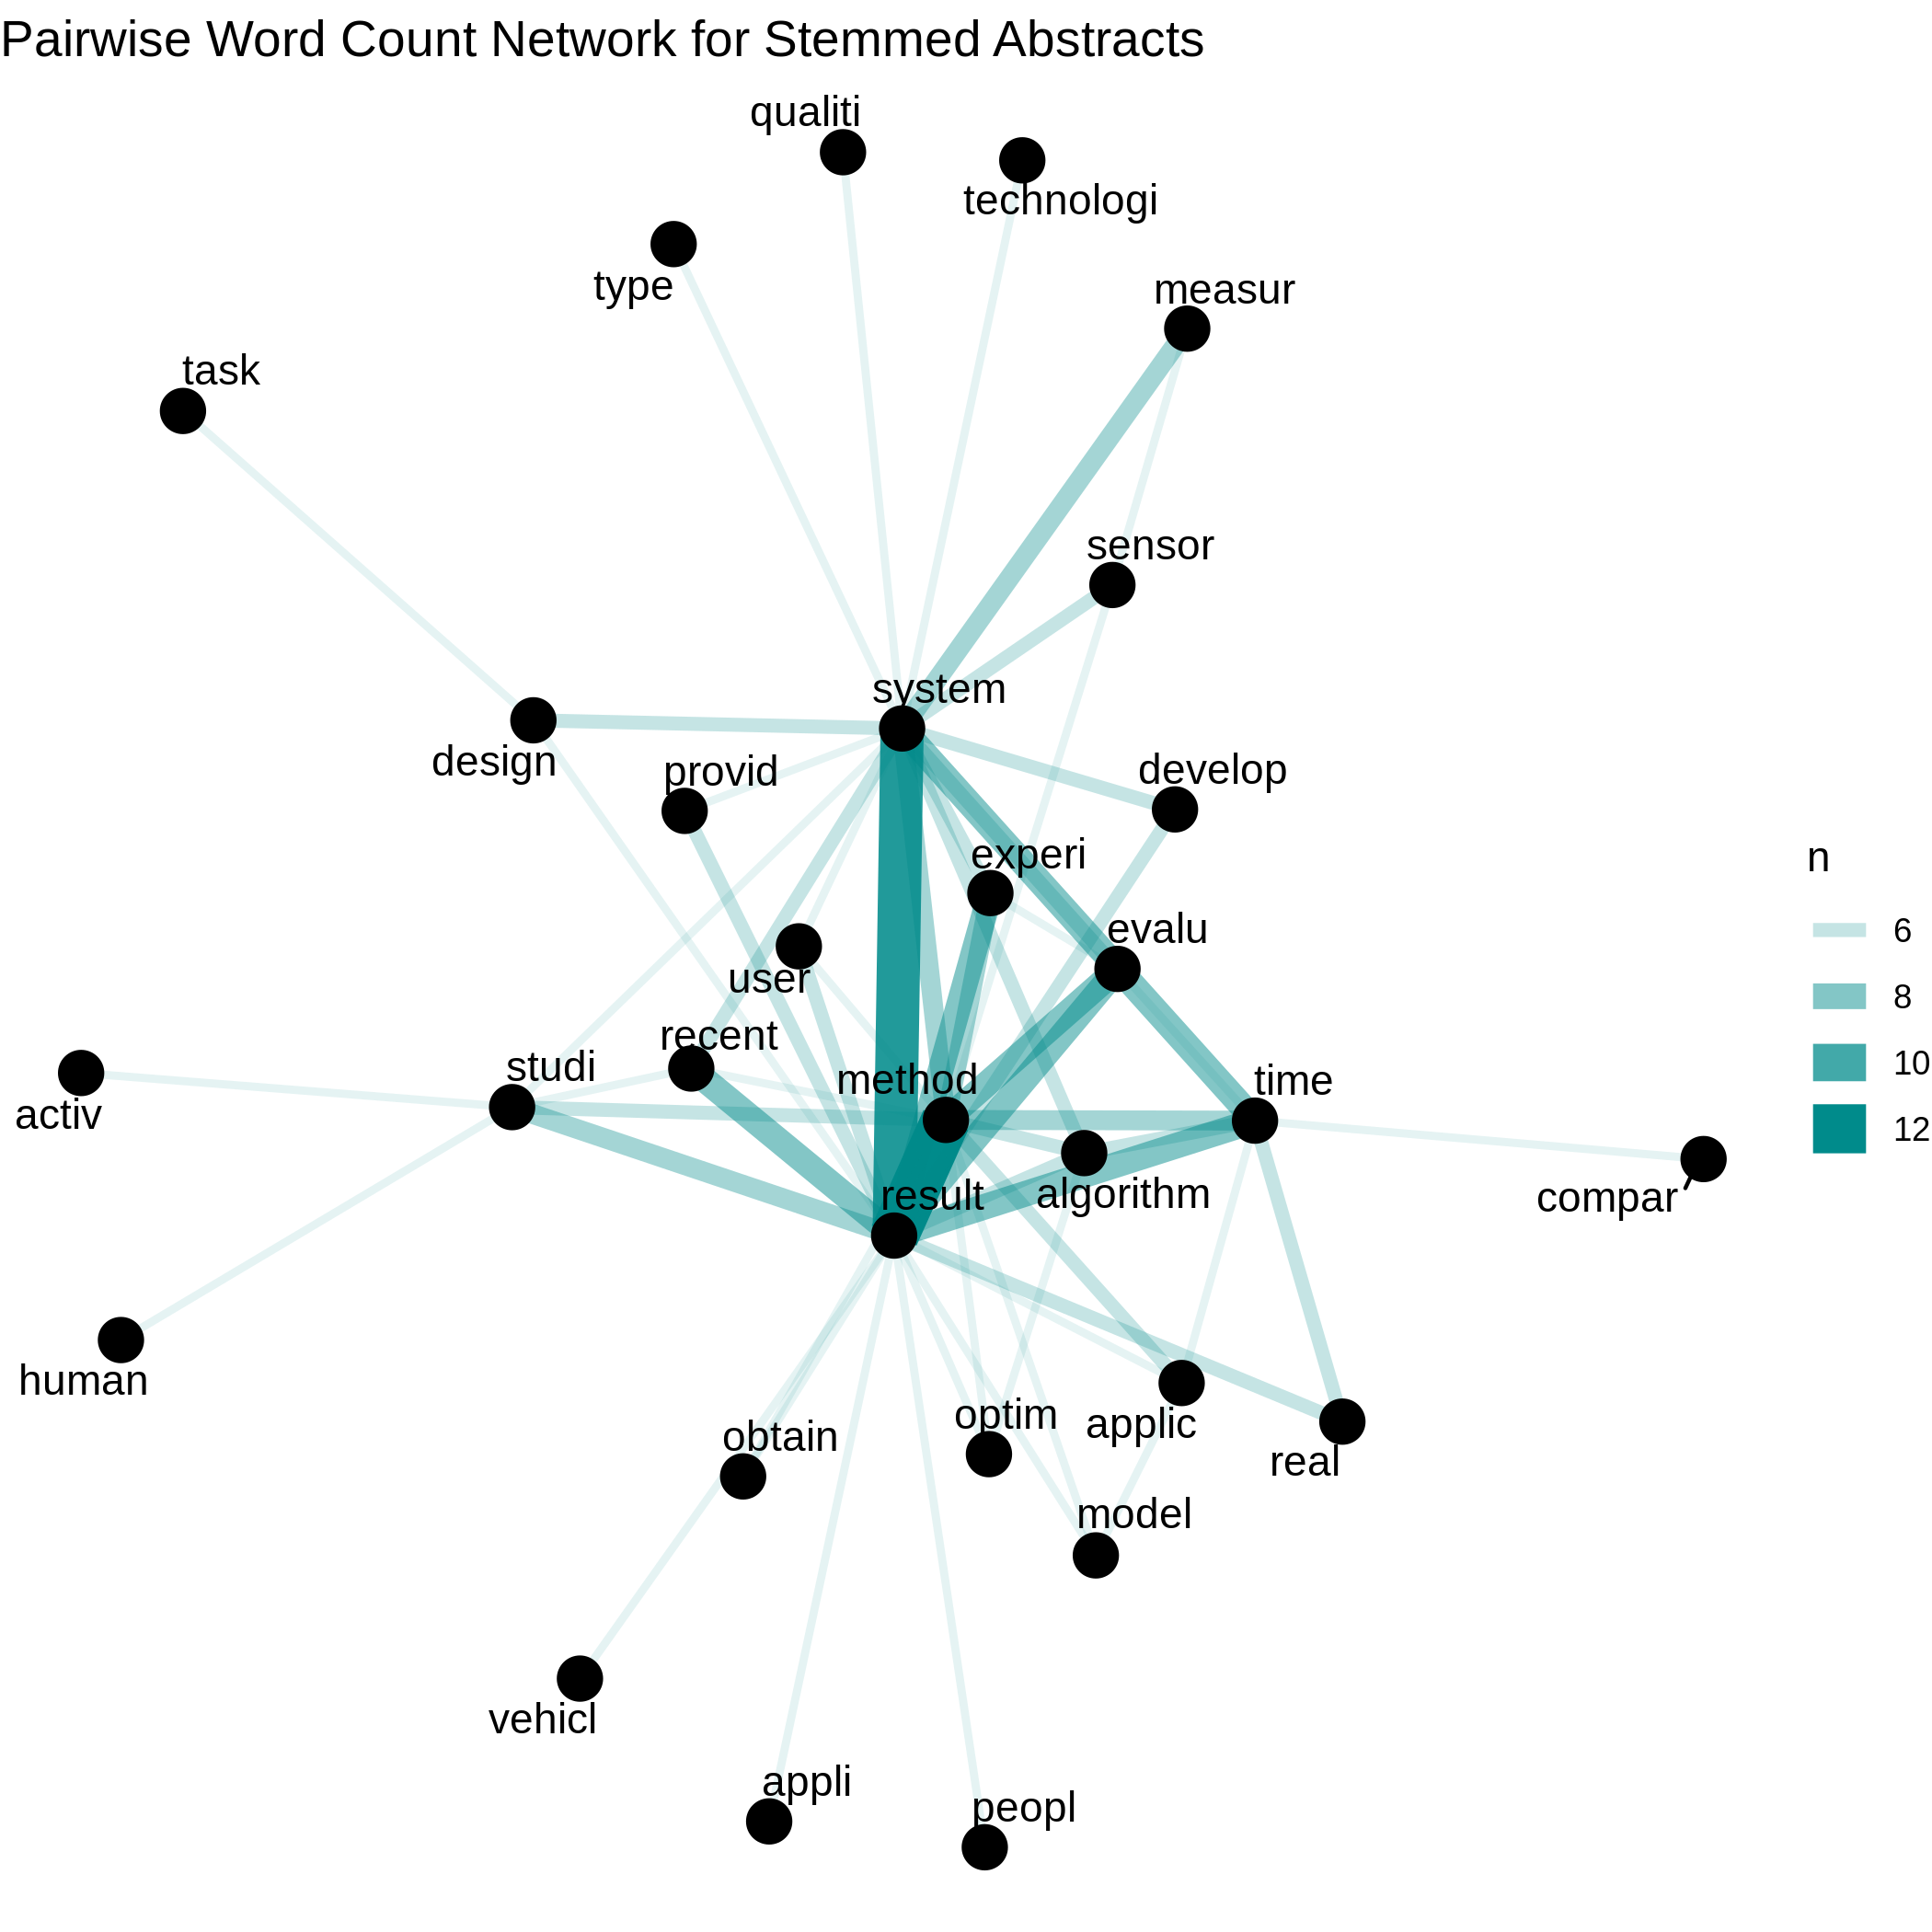

In [18]:
set.seed(1234)
abstract_word_pairs %>%
  filter(n >= 5) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = n, edge_width = n), edge_colour = "cyan4") +
  geom_node_point(size = 5) +
  geom_node_text(aes(label = name), repel = TRUE, 
                 point.padding = unit(0.2, "lines")) +
  ggtitle("Pairwise Word Count Network for Stemmed Abstracts") +
  theme_void()

Word counts do not separate into clusters, although the counts are plotted for 6 occurences and larger. 

### Word Correlations within Paper Abstracts

Word correlation are measured by the phi coefficient. Latter is a special case of pearson's correlation coefficient for binary variables. Source: https://en.wikipedia.org/wiki/Phi_coefficient

In this use case, the phi coefficient correlates two words and expresses the ratio of how often they occur together in all papers' abstracts, or neither do, relative to how often they occur separately.

So, $\phi = 1$ indicates that two words only occur together in papers' abstracts and never alone. Similarly, $\phi = -1$ indicates that two words only occur separately in a paper's abstract, but never together.

In [19]:
# we exclude very rare words, i.e.  
# a word must appear at least a number of times to be considered.
word_cors <- dataset_abstract %>%
    group_by(word) %>%
    filter(n() >= 4) %>% # word must appear at least this often
    ungroup() %>%
    pairwise_cor(word, filename, sort = TRUE)


In [20]:
# top_n frequent words in all abstracts
abstract_topn_word <- dataset_abstract %>% 
    count(word, sort=TRUE) %>%
    top_n(5,n) %>%
    select(word) %>% as.vector

abstract_topn_word <- abstract_topn_word$word

Selecting by correlation



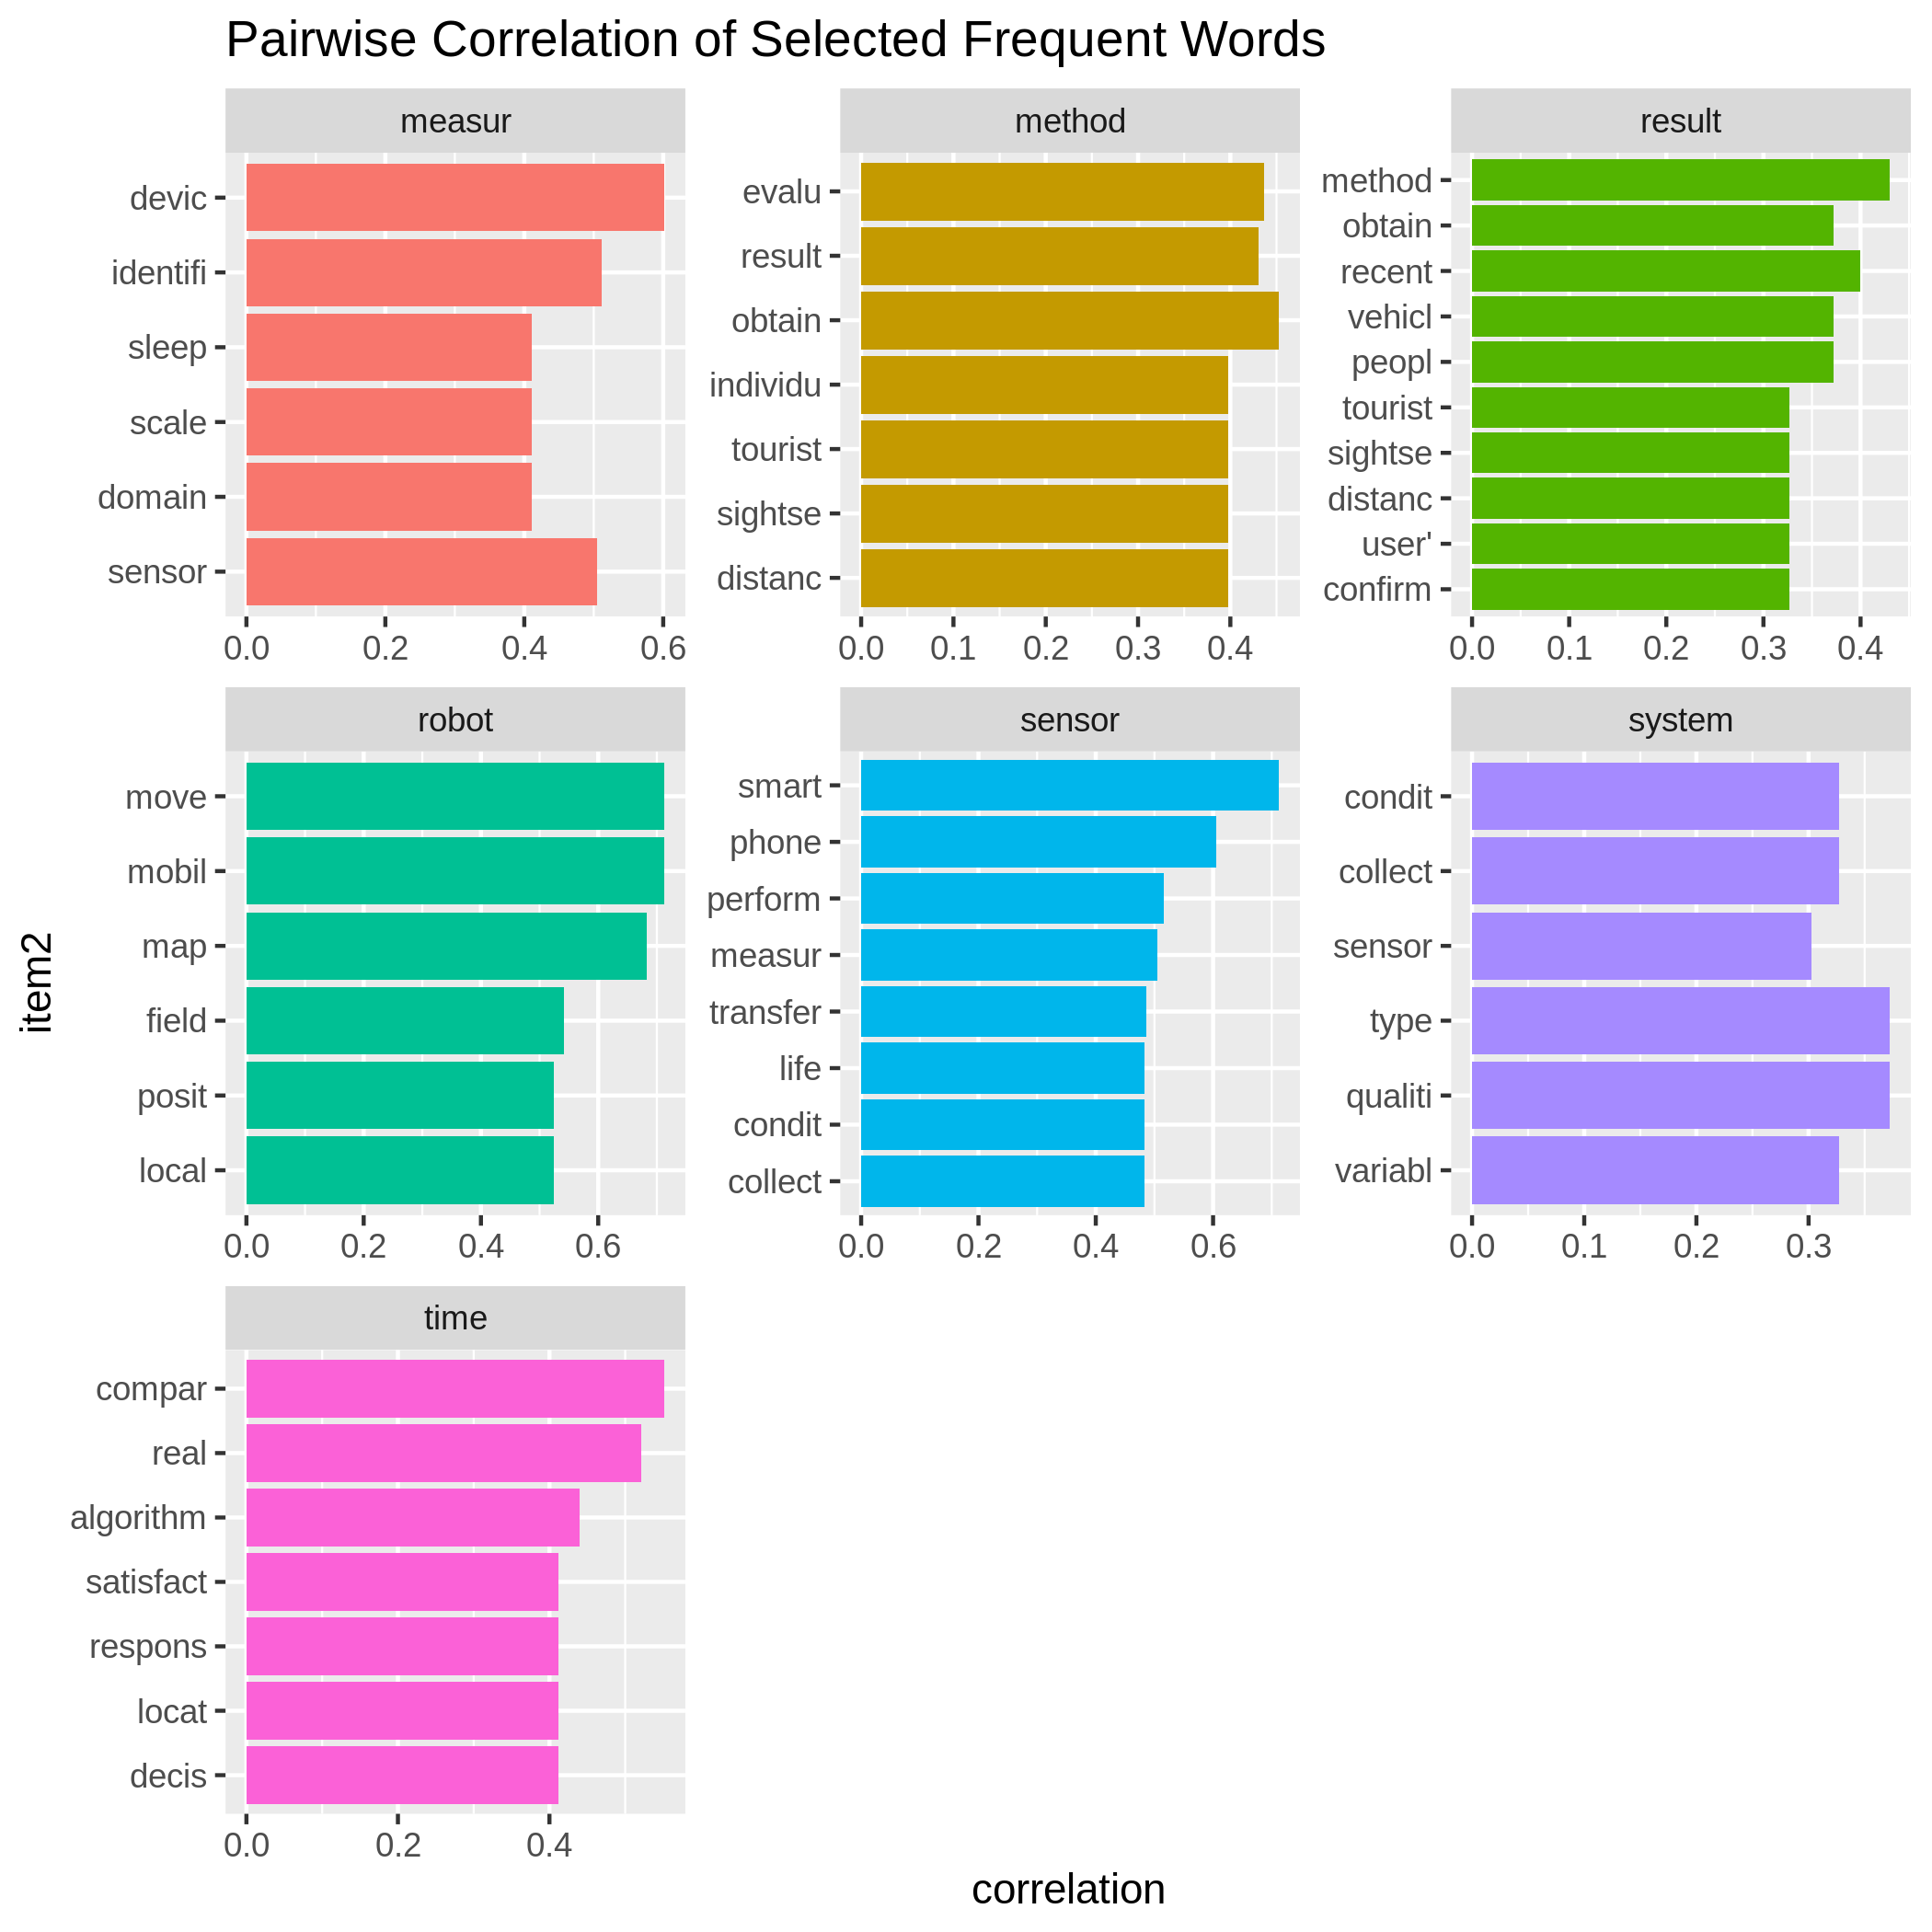

In [21]:
# plot the word correlation of the top_n words
# with other words
word_cors %>%
  filter(item1 %in% abstract_topn_word) %>%
  group_by(item1) %>%
  top_n(6) %>%
  ungroup() %>%
  mutate(item2 = reorder(item2, correlation)) %>%
  ggplot(aes(item2, correlation, fill = item1)) +
  geom_bar(stat = 'identity', show.legend = FALSE) +
  facet_wrap(~item1, scales = 'free') +
  ggtitle("Pairwise Correlation of Selected Frequent Words") +
  coord_flip()

We plot the graph of all _strong positive_ correlations. This is not limited to the above selection of frequent words.

At first we devise an algorithm to select an appropriate correlation coefficient threshold. The threshold decides on the smallest word correlation to be included in the plot. 

The algorithm iterates through possible thresholds, creates a graph for each value and investigates number of clusters (= subgraphs disconnected from others) and the diameter. An interesting graph is one with a high number of clusters and a large avg. diameter across clusters. The threshold is the one which maximizes the following sum
$$
\text{no. of clusters } + 0.5\cdot \text{ mean diameter}
$$

In [22]:
corr_filter <- seq(0.01, .99, by=0.01) %>% map_df( function(r) {
  word_cors %>%
  filter(correlation > r) %>%
  graph_from_data_frame() %>% 
  decompose(min.vertices=2) %>% 
  sapply(., diameter) %>% list() %>% 
  map_df(~ data_frame(components = length(.), mean_diameter = mean(.))) %>%
  mutate(r=r)
  }) %>% mutate(s=components+0.5*mean_diameter) %>%
  filter(mean_diameter>1) %>% 
  group_by(s) %>% 
  summarise(r=max(r), comps=max(components)) %>% 
  top_n(1, s)

cat("Correlation coefficient threshold: ", corr_filter$r)

Correlation coefficient threshold:  0.71

After we have found the correlation threshold, we now plot the word correlations greater than this threshold. We expect to see a nice separation of groups of words.

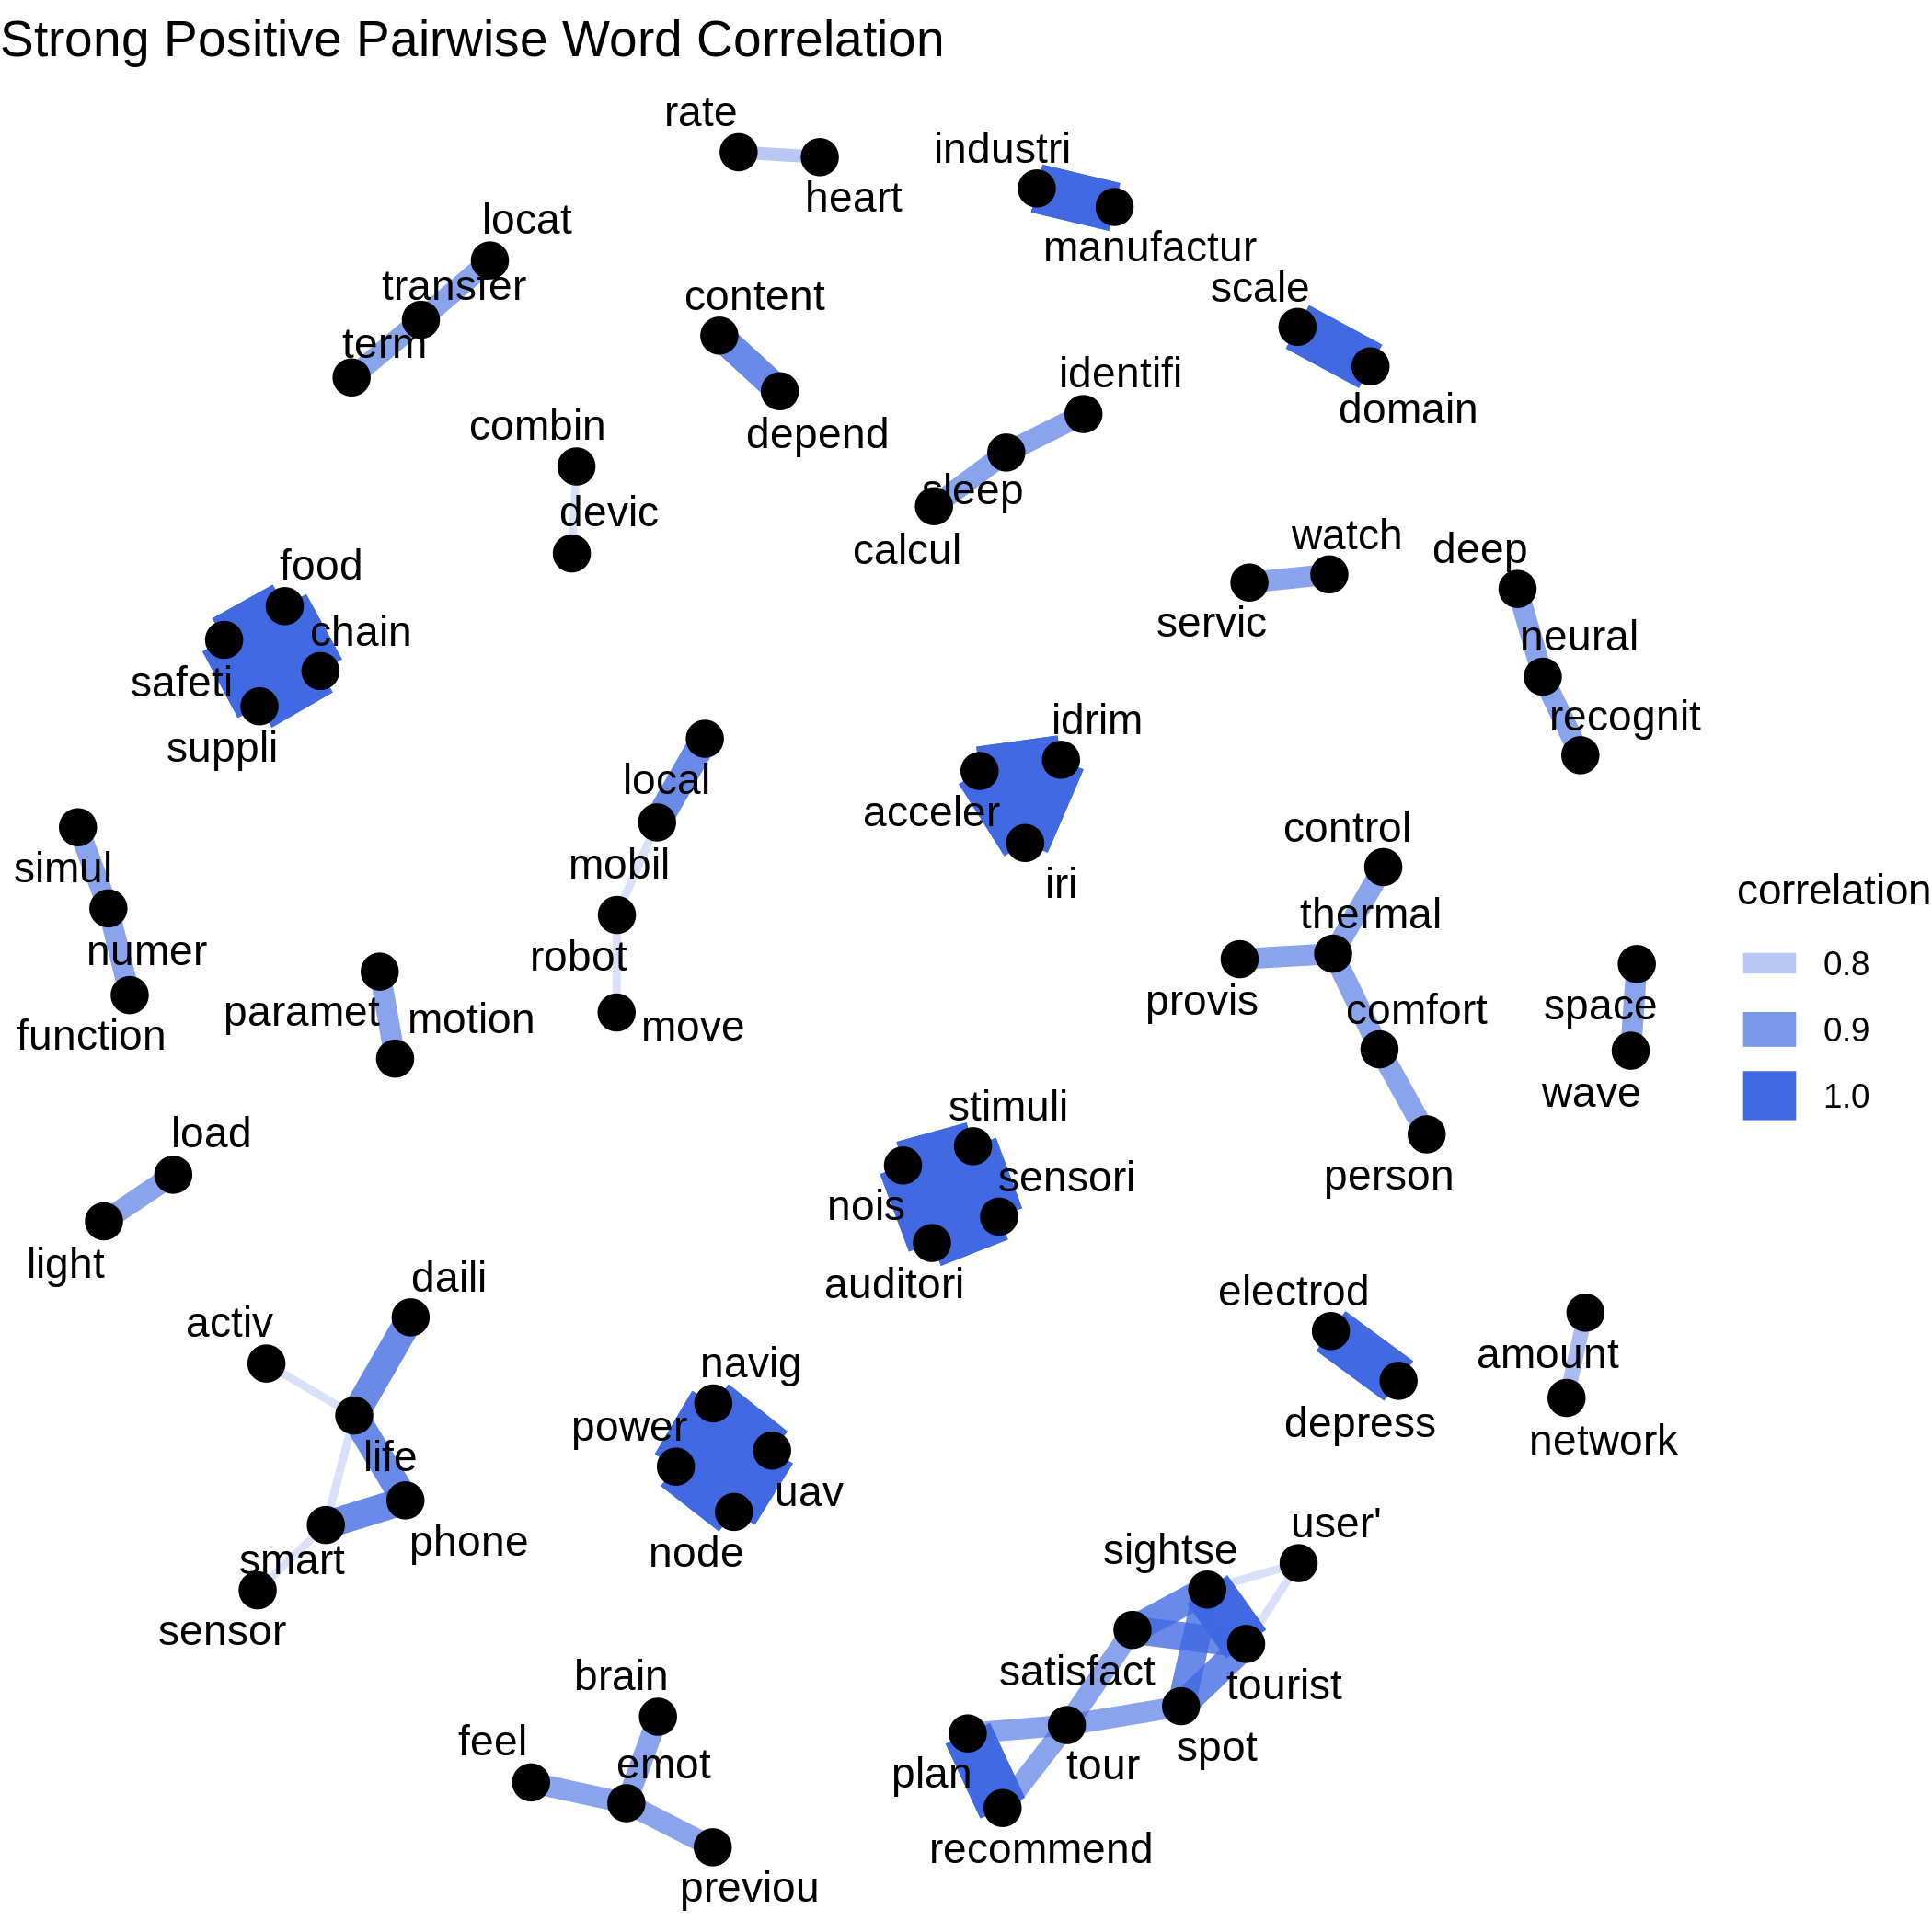

In [23]:
# we plot the graph of all strong positive correlations, i.e.
# not limited to the above selection of frequent words
set.seed(1234)

# plot the graph
word_cors %>%
  filter(correlation > corr_filter$r) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = correlation, edge_width = correlation), edge_colour = "royalblue") +
  geom_node_point(size = 4) +
  geom_node_text(aes(label = name), repel = TRUE,
                 point.padding = unit(0.2, "lines")) +
  ggtitle("Strong Positive Pairwise Word Correlation") +
  theme_void()

## Analysis

* Important paper reading list
* Paper topics


### Calculating tf-idf Statistic

The term frequency / inverse document frequency is a statistic indicating the importance of a word or term within a corpus of documents. It combines the term's occurrence within a single document (tf statistic) with its occurrence in the document corpus (idf statistic).

A term becomes more important, i.e. receives a larger tf-idf value, if it frequently occurs within a document, but less frequent in the corpus. The lower document frequency (df) corresponds to a larger _inverse_ df, therewith result in a larger tf-idf value.

In [24]:
abstract_tfidf <- dataset_abstract %>% 
  count(filename, word, sort = TRUE) %>%
  ungroup() %>%
  bind_tf_idf(word, filename, n)

### Important Paper Reading List

We list papers with the Top 10 important terms according to their tf-idf statistic. If a paper has more than one important term from this top_n list, we will include them all. The corresponding tf-idf statistic is then the median value of all included important terms. As a result, we compile a paper reading list sorted by the terms' median tf-idf statistic.

In [25]:
# top_n important words by td-if statistic
abstract_topn_tfidf <- abstract_tfidf %>% 
  filter(!near(tf, 1)) %>% # exclude texts with a single term
  top_n(10, tf_idf) 

# papers to read
papers_to_read <- abstract_topn_tfidf %>%
  group_by(filename) %>%
  summarise(important_words = paste(word, collapse=", "), median_tfidf=median(tf_idf)) %>%
  arrange(-median_tfidf) %>%
  inner_join(dataset, by=c("filename")) %>%
  select(filename, title=MET_TITLE, important_words, median_tfidf)
papers_to_read  

filename,title,important_words,median_tfidf
<chr>,<chr>,<chr>,<dbl>
AISE23-0186.pdf,Food Supply Chain Management System for Product History Using Blockchain,food,0.4630095
AISE23-0178.pdf,Investigation of Dynamic Control of Learning Materials Based on Brain Waves,learn,0.3915486
IWSSS19_paper_5.pdf,System for motivating ethical consumption behavior using dongle interface application,ethic,0.3433987
AISE23-0244.pdf,Preference-Aware Video Summarization for Virtual Tour Experience,video,0.3361408
IWSSS19_paper_6.pdf,An Approach for Measuring IoT Interoperability using Causal Modeling,interoper,0.3239611
iwsss16_paper1.pdf,Detecting Moving Objects Using Optical Flow with a Moving Stereo Camera,move,0.3090857
iwsss16_paper3.pdf,Damage Detector: The Damage Automatic Detection of Compartment Lines Using A Public Vehicle and A Camera,compart,0.2901961
IWSSS19_paper_2.pdf,Advancement of IoH/IoT,assist,0.2822455
11_312.pdf,Conceptual Design of a Collective Energy-Efficient Physiologically-Controlled System for Thermal Comfort Delivery in an Office Environment,thermal,0.2558117


### Paper Topics

We now want to ask what are the papers about. Therefore, we model paper topics from paper abstracts and classify them accordingly.  The tool to apply is the Latent Dirichlet allocation (LDA). The papers' abstracts are documents. A LDA topic is a set of terms from the document corpus. Topics are factors or explanations where documents are similar to each other. As a result, a document is described as a weighted composition of topics. LDA derives set of word for each topic as well as the composition of topics for each document at the same tome from the document corpus in an unsupervised way.

For instance, LDA derives two topics, which are simply enumerated as *1* and *2* . The most important words in the set for topic *1* are "algorithm", "data", "performance", the important word for topic *2* are "data", "system", "network". A paper abstract may then be classified as 80% topic *1* and 20% topic *2*. 

#### Topic Modeling

We apply LDA topic modeling to the entire document corpus of paper abstracts, i.e. topics are derived from all paper abtracts from all workshops between 2016 and 2019. Please note that abstracts were previously stemmed.

In [26]:
num.topics <- 9
num.topic_terms <- 4

We create a DocumentTermMatrix (dtm) containing the frequency as absolute word counts of each word for each document.

In [27]:
word_counts <- dataset_abstract %>%
  count(filename, word, sort = TRUE) %>%
  ungroup()

#word_counts

abstract_dtm <- word_counts %>%
  cast_dtm(filename, word, n)

abstract_dtm

<<DocumentTermMatrix (documents: 31, terms: 996)>>
Non-/sparse entries: 1800/29076
Sparsity           : 94%
Maximal term length: 21
Weighting          : term frequency (tf)

The LDA model is fitted using the dtm using the previously specified number of topics. The seed parameter let us deterministically re-run the LDA procedure.

In [28]:
library(topicmodels)

# be aware that running this model is time intensive
desc_lda <- LDA(abstract_dtm, k = num.topics, control = list(seed = 1234))
desc_lda

A LDA_VEM topic model with 9 topics.

The next plot shows all topics from the LDA model. Each LDA topic is a set of terms. We extract the `num.topic_terms` important ones determined by their *per-topic-per-word probabilities*, the so called $\beta$ value. The cell shows them in descreasing order.

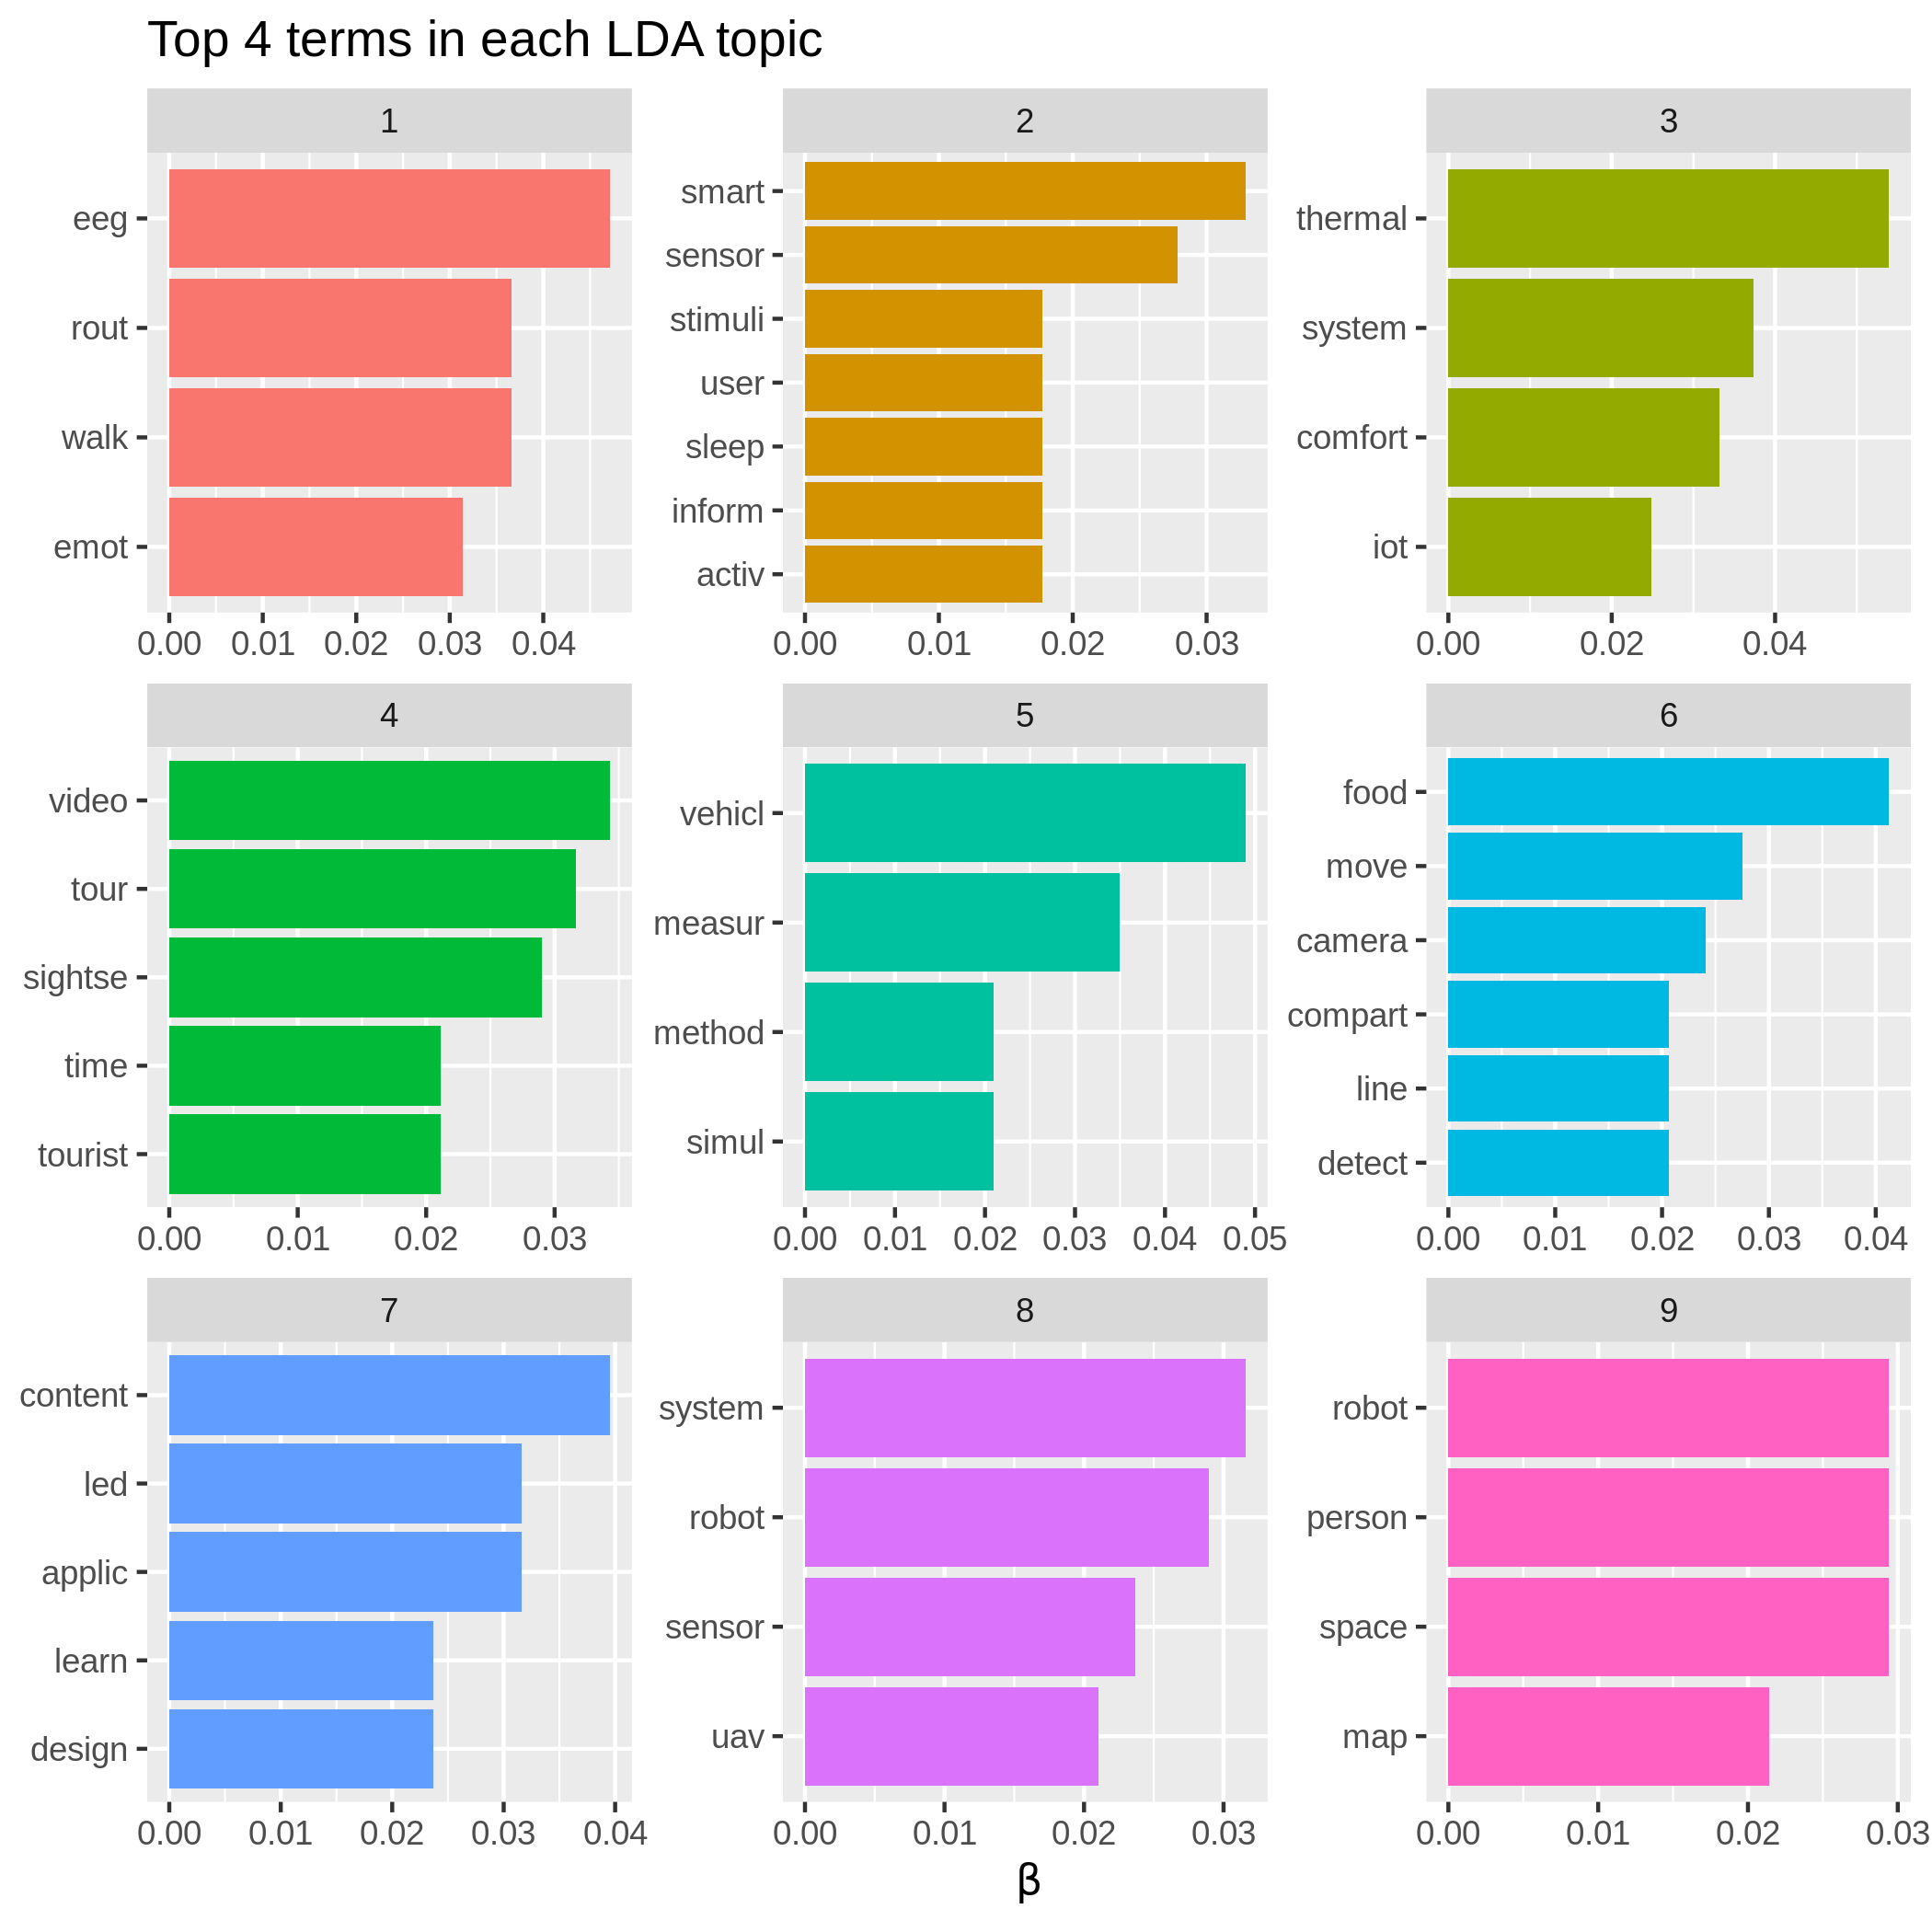

In [29]:
# tidying lda
lda_beta <- tidy(desc_lda, matrix = "beta")

# most relevant term in decreasing order by \beta value
top_terms <- lda_beta %>%
  group_by(topic) %>%
  top_n(num.topic_terms, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)
#top_terms

top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  group_by(topic, term) %>%    
  arrange(desc(beta)) %>%  
  ungroup() %>%
  mutate(term = factor(paste(term, topic, sep = "__"), 
                       levels = rev(paste(term, topic, sep = "__")))) %>%
  ggplot(aes(term, beta, fill = as.factor(topic))) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  scale_x_discrete(labels = function(x) gsub("__.+$", "", x)) +
  labs(title = paste("Top", num.topic_terms, "terms in each LDA topic"),
       x = NULL, y = expression(beta)) +
  facet_wrap(~ topic, ncol = 3, scales = "free")

Topics are just enumerated. Studying the terms, we can assign names. The author's personal preference has determined the following topic names.

**Note:** This only works for a previously fixed number of topics. If the LDA processing is changed in this respect, the topic names have to be newly assigned.

In [30]:
topic_name <- c("EEG", # topic 1
                 "Smart sensor", # topic 2 
                 "Smart home",
                 "Recreation",
                 "Vehicle / Traffic",
                 "Smart shop",
                 "Application design",
                 "Autonomous UAV systems",
                 "People and robot systems") # topic n
topic_names <- data.frame(topic=c(1:length(topic_name)), topic_name)
#topic_names

#### Topics Distribution across Workshops

Named topics now help to better express the corpus of paper abstracts as a weighted compositions of LDA topics. 

We will show how topics derived from the overall series are distributed across the paper abstracts of each workshop occasion. For instance, one gets an expressive view what topics are stronger or weaker represented in past workshops than in recent occasions. The result displays the variation of topics in time throughout the workshop's history.

The $\gamma$ value of the LDA model specifies the per-document-per-topic probabilities. This is represents the wheighted composition of topics for each paper abstract.

In [31]:
lda_gamma <- tidy(desc_lda, matrix = "gamma")

lda_gamma <- lda_gamma %>%
    inner_join(dataset, by=c("document" = "filename")) %>%
    inner_join(topic_names, by=c("topic")) %>%
    select(document, topic, topic_name, year, gamma)

The plot below shows boxplots for each topic and year. It also marks the mean of $\gamma$ as blue point and the max of $\gamma$ as red triangle.

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“`fun.y` is deprecated. Use `fun` instead.”


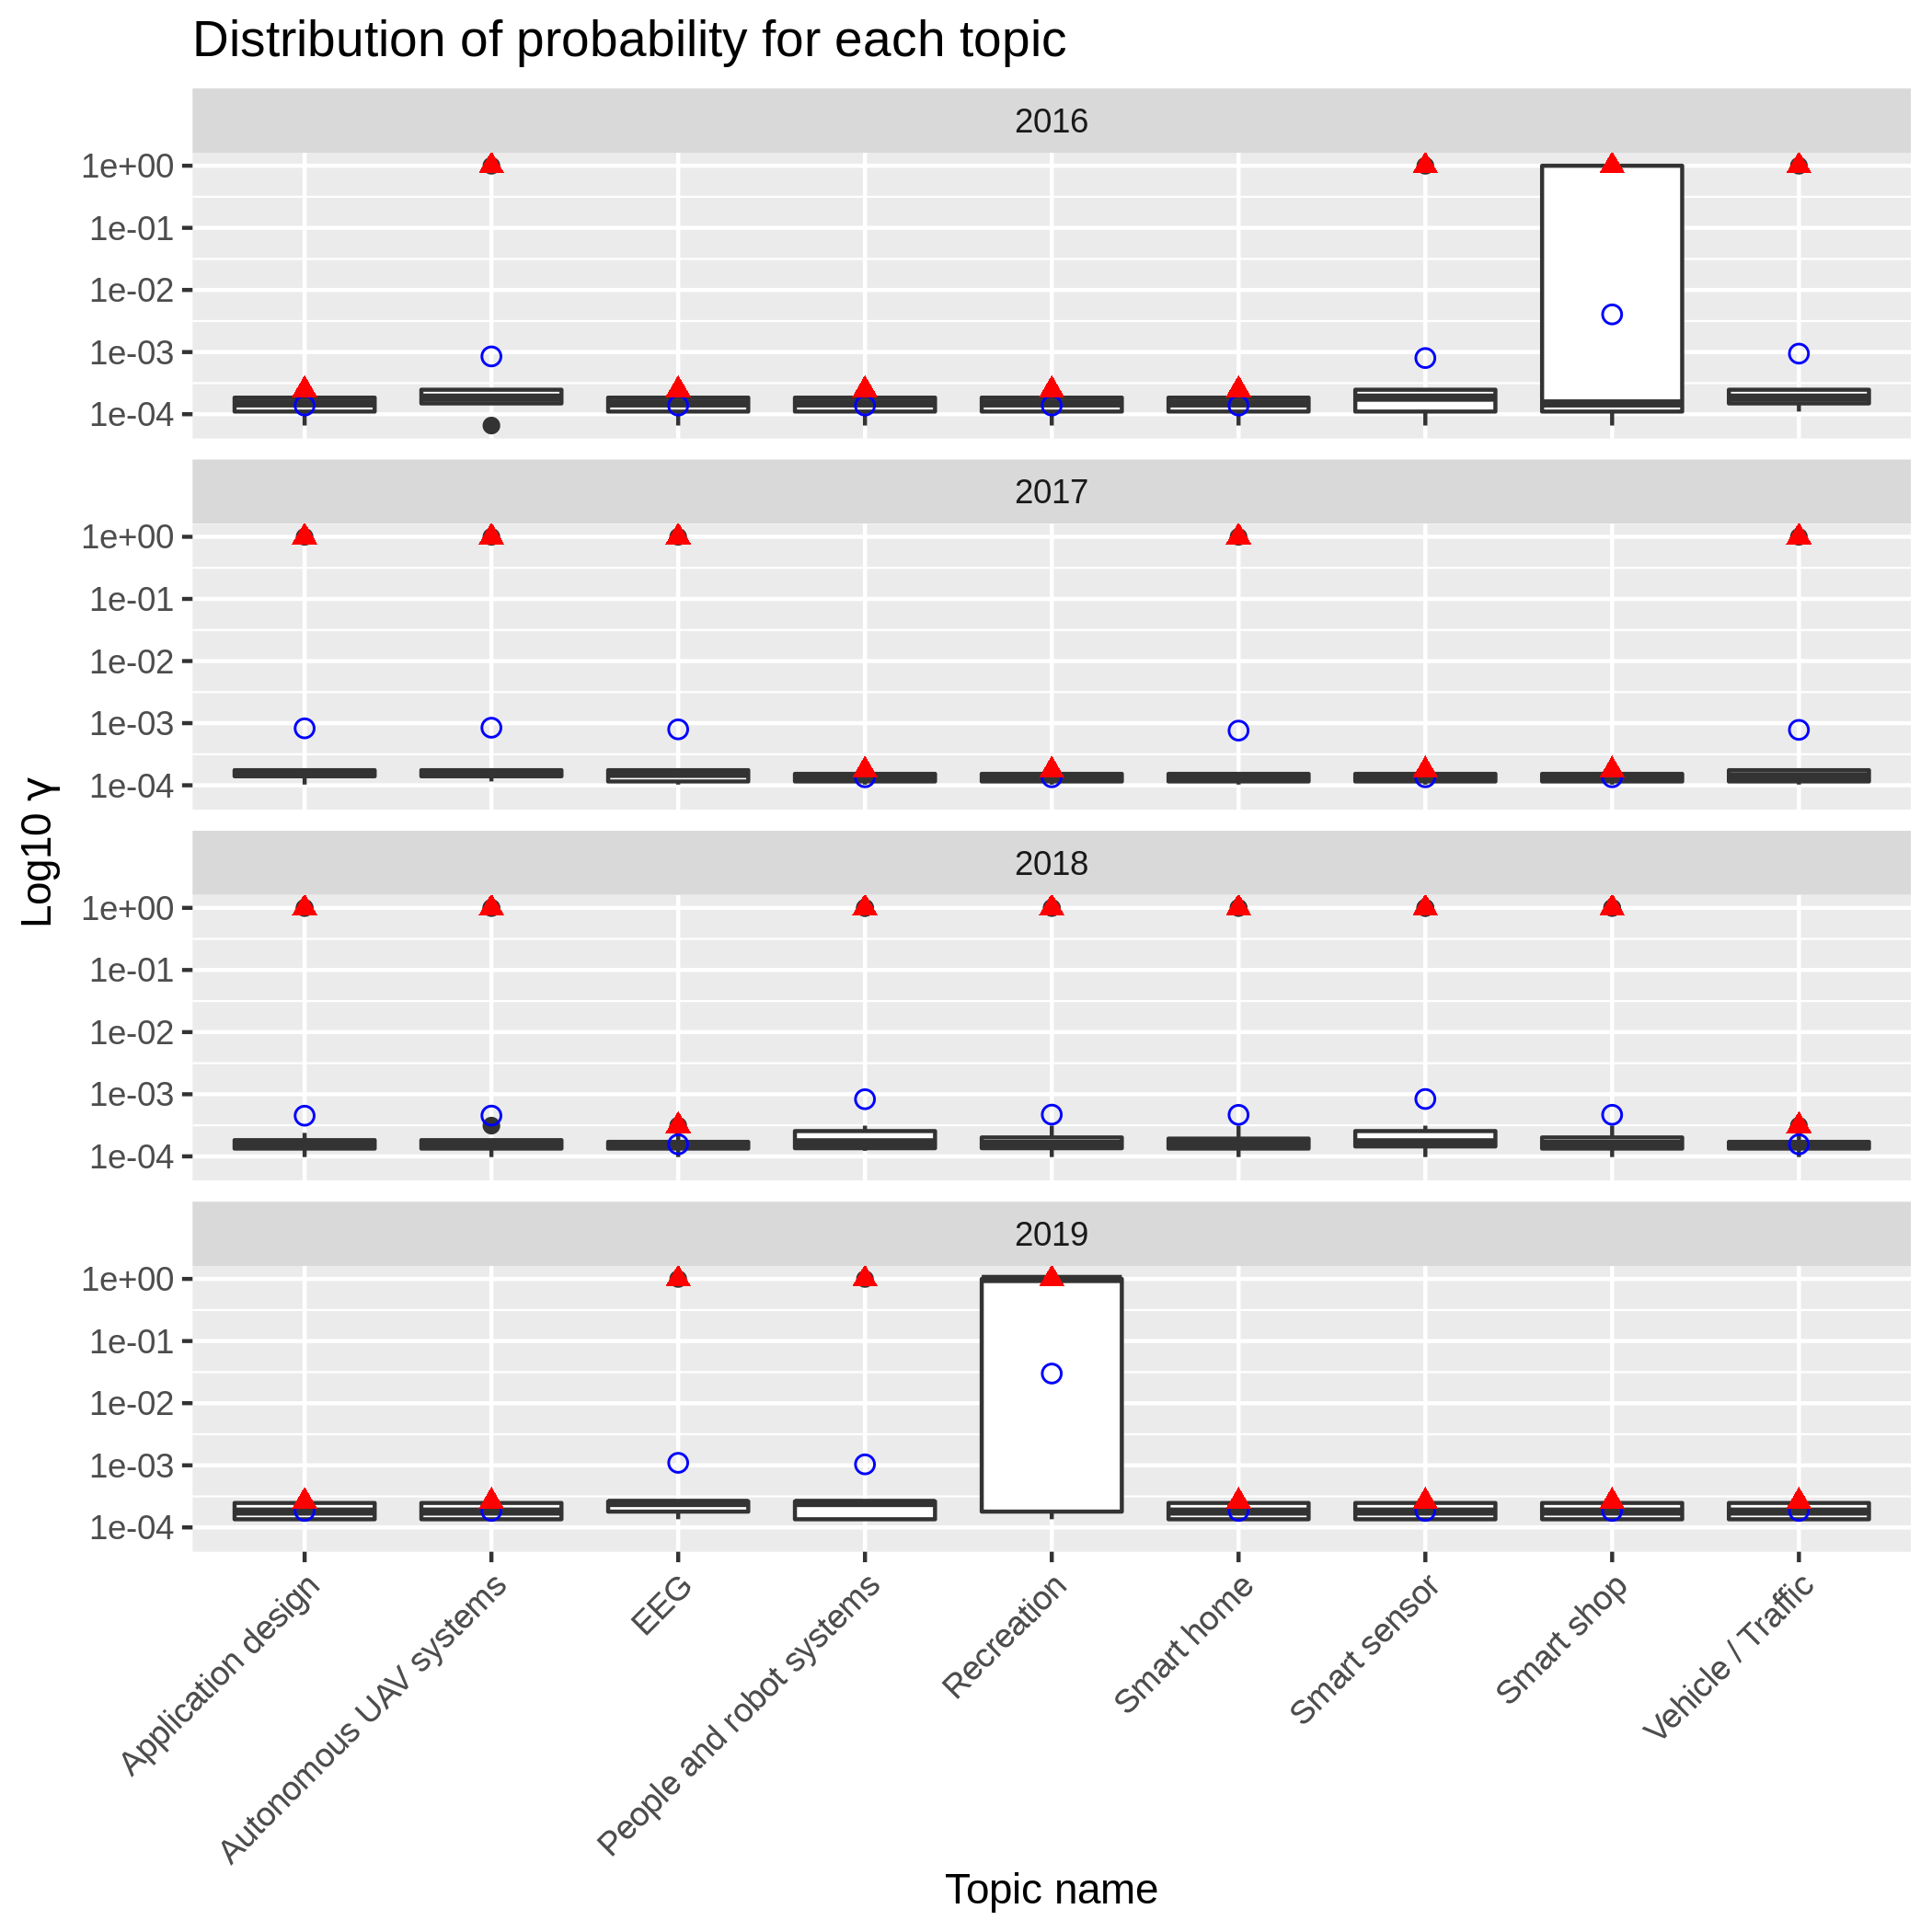

In [32]:
plot.topics_per_year <- ggplot(data=lda_gamma, aes(x=topic_name, y=gamma)) + 
    geom_boxplot() + 
    stat_summary(fun.y=mean, geom="point", color="blue", shape=1, size=2) + 
    stat_summary(fun.y=max, geom="point", color="red", shape=17, size=2) +
    scale_y_log10()
plot.topics_per_year +
    facet_wrap(~year, ncol=1) +
    labs(title = "Distribution of probability for each topic", 
         x = "Topic name", y = expression(paste("Log10 ", gamma) )) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

Immediately, one sees that the topic Recreation dominates the workshop in 2019 as indicated by the large boxplot. Several papers report in their abstracts about this topic with a very large probability. In the same line the topic Smart Shop dominates the workshop in 2016.

The blue points indicate the mean values of $\gamma$. In almost all cases it lays outside of the central box. This implies that the mean value is dominated by only a very few or even only one paper. The plots mark those papers as red triangles indicating max values of $\gamma$. They display a strong focus on a topic and are probably noticeable to the audience. Topic-dominating papers make topics more distinctive and prominent. As a consequence, they may define an emphasis and a workshop's theme. 

Apart from Smart shop topic in the 2016 workshop, larger mean values appear also for topics on Autonomous UAV systems, Smart sensors and Vehicle / Traffic which have themed the workshop in that year. In 2017, the workshop theme shifted when topics on Autonomous UAV systems and Vehicle / Traffic remained to be present, but Application Design, EEG and Smart home became more visible. Almost all topics were covered on average in the 2018th edition of the workshop, when the average theme shifted to EEG, People and robot systems and Recreation in 2019.

#### Papers from Dominating Topics 

Finally, let's list the papers from those topics which have dominated the workshops in 2016 and 2019.

In [33]:
lda_gamma %>%
    filter(year==2016 & topic_name=="Smart shop") %>%
    arrange(-gamma) %>% top_n(2, gamma) %>%
    inner_join(dataset, by=c("document" = "filename")) %>%
    select(document, year=year.x, gamma, topic_name, MET_TITLE)

document,year,gamma,topic_name,MET_TITLE
<chr>,<dbl>,<dbl>,<fct>,<chr>
iwsss16_paper3.pdf,2016,0.9985200,Smart shop,Damage Detector: The Damage Automatic Detection of Compartment Lines Using A Public Vehicle and A Camera
iwsss16_paper1.pdf,2016,0.9980185,Smart shop,Detecting Moving Objects Using Optical Flow with a Moving Stereo Camera


It is imaginable from the titles that this classification is reasonable. However, this notebook just provides hints. Not all of them are correct. A user is still required to justify the recommendations.

In [34]:
lda_gamma %>%
    filter(year==2019 & topic_name=="Recreation") %>%
    arrange(-gamma) %>% top_n(3, gamma) %>%
    inner_join(dataset, by=c("document" = "filename")) %>%
    select(document, year=year.x, gamma, topic_name, MET_TITLE)

document,year,gamma,topic_name,MET_TITLE
<chr>,<dbl>,<dbl>,<fct>,<chr>
IWSSS19_paper_8.pdf,2019,0.9989162,Recreation,A Method for Generating Multiple Tour Routes Balancing User Satisfaction and Resource Consumption
IWSSS19_paper_6.pdf,2019,0.9980185,Recreation,An Approach for Measuring IoT Interoperability using Causal Modeling
IWSSS19_paper_5.pdf,2019,0.9978999,Recreation,System for motivating ethical consumption behavior using dongle interface application


The paper *"An Approach for Measuring IoT Interoperability using Causal Modeling"* was co-authored by the notebook's author. It is unclear why this paper was classified into the Recreation topic.  It definitely does not fit there.

## Conclusion

We review the research questions from the beginning and refer to results from this notebook as answers.

* How to explore the papers' context to achieve a general understanding?

A simple descriptive overview of workshop's paper counts for each year was given. Wordclouds on title and abstracts provided some qualitative exploration. Word counts have helped to identify additional stopwords. Bi- and trigrams revealed common word sequences.

* What are strong relations connecting all documents with each other?

Word counts for titles and abstracts have not shown a meaningful clustering. Word correlation for frequent word as well as clustering on all word correlations have identified relevant word occurences.

* What are relevant papers to read?

A list of the Top 10 papers based on the tfidf metric was provided.

* What are topics and how do papers correspond to these topics?

Using LDA topic modeling we have identified 9 topics with 4 term per topic. We have named the topics according to the notebook's author personal preferences.

* Topic evolution: How much are past topics still present in  IWSSS?

Across the workshop series a plot showed the dominant topics and identified a certain themes, formed by topic dominating papers. Latter display a strong focus on a topic and are probably noticeable to the audience. A list of papers from the dominant topics in 2016 and 2019 concludes the investigation.

## Future Work

The workshop's call for paper offers a curated list of topics proposed by the organizers. As a next step, we want to map the curated workshop topics to the topics found by LDA. An promising approach to utilize is the use of word vectors. Similarity of word vectors sourcing from both, the curated topics and LDA topics, may provide a way to map them.